In [10]:
# System management 
import os
import time
import pickle
import dill
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd
import re
pd.options.display.max_rows = 400

# Scikit-learn
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, classification_report
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFECV

# Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm 
from xgboost import XGBClassifier

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
from hyperopt.pyll.base import scope

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# MLFlow tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns
plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })
%matplotlib inline
sns.set_theme(palette='Set1')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'


In [11]:
# Set main directory
project_path = '/Users/felipelima/Documents/projets/credit-scoring/'
os.chdir(project_path)

In [12]:
# Load data
data = pd.read_csv('data/processed/train_feature_engineering_encoded.csv').drop(columns=['SK_ID_CURR'])
#data_test = pd.read_csv('data/processed/test_feature_engineering_encoded.csv').drop(columns=['SK_ID_CURR'])

#### MLFlow 

Set MLFlow tracking

In [13]:
# Create experiment
experiment_name = 'credit_scoring'
# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)
# If the experiment doesn't exist, create it
if experiment is None: 
    mlflow.create_experiment(experiment_name)
# Set the experiment 
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/felipelima/Documents/projets/credit-scoring/mlruns/884488096939595672', creation_time=1700889868350, experiment_id='884488096939595672', last_update_time=1700889868350, lifecycle_stage='active', name='credit_scoring', tags={}>

#### Data pre-processing

In [14]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET]
features = data.drop(columns=TARGET)
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

##### Missing values

Fill the missing values with a simple imputer

In [15]:
# Check missing values
nan_values = data.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 32442173 (18.35%)


In [16]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)
features_fill = pd.DataFrame(features_fill, columns=features_names)

In [17]:
nan_values = features_fill.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 0 (0.00%)


#### Split data

In [18]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(246004, 574) (246004,)
(61502, 574) (61502,)


#### Data distribution

In [19]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test)
print('Training target statistics:', y_train_counter)
print('Testing target statistics:', y_test_counter)

# Print ratio
print('Ratio is 1:{:.0f} in training/validation set'.format(y_train_counter[0] / y_train_counter[1]))
print('Ratio is 1:{:.0f} in test set'.format(y_test_counter[0] / y_test_counter[1]))

Training target statistics: Counter({0.0: 226154, 1.0: 19850})
Testing target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in training/validation set
Ratio is 1:11 in test set


In [20]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print('Training target statistics:', Counter(y_res))
print('Ratio is 1:{:.0f} in training/validation set'.format(Counter(y_res)[0] / Counter(y_res)[1]))
print('Validation target statistics:', Counter(y_test))
print('Ratio is 1:{:.0f} in test set'.format(Counter(y_test)[0] / Counter(y_test)[1]))

Training target statistics: Counter({0.0: 113077, 1.0: 113077})
Ratio is 1:1 in training/validation set
Validation target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in test set


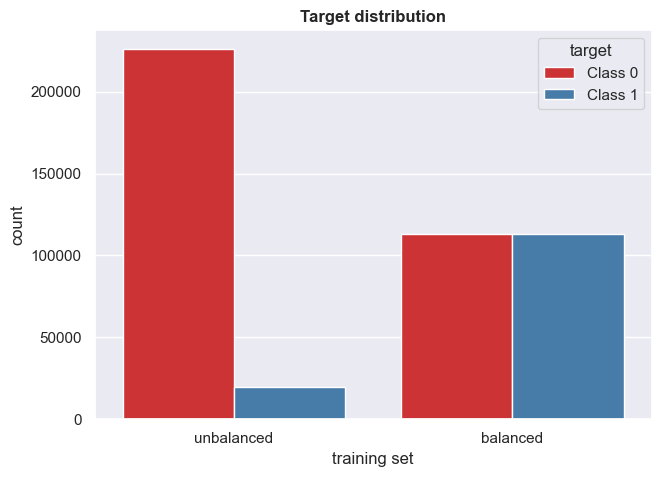

In [21]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title('Target distribution')
plt.show()

The resulting data is now balanced. However, since we will test using cross validation, the resampling step shall be done for each cross validation iteration (inside the pipeline).

#### Metric functions

In [22]:
# 1 --> dont repay
# 0 --> repay
# Custom loss function based on business rule =  
# cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)
def business_loss_func(y_true, y_pred): # 0 --> best # 1 --> worst
    #beta=10
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    #precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    #recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    #score = ((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

    #cost = (fn + 10 * fp) / (len(y_true))
    #score = 1 - cost

    tn_rate, tp_rate, fp_rate, fn_rate = 1, 1, -1, -10

    total_default = tp + fn
    total_not_default = tn + fp

    total_gain = tn*tn_rate + tp*tp_rate + fp*fp_rate + fn*fn_rate
    min_gain = total_not_default*tn_rate + total_default*fn_rate
    max_gain = total_not_default*tn_rate + total_default*tp_rate

    score = (total_gain - min_gain) / (max_gain - min_gain)

    return score

"""def business_scorer(y_true, y_pred): 
    return business_loss_func(y_true, y_pred)"""

business_scorer = make_scorer(business_loss_func, greater_is_better=True)

def specificity_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity
specificity_scorer = make_scorer(specificity_score_func, greater_is_better=True)

def false_positive_rate_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr
fpr_scorer = make_scorer(false_positive_rate_score_func, greater_is_better=False)

#### Classification

In [23]:
def plot_cf_matrix_roc_curve(y_true, y_pred, y_pred_proba, feature_importance=None):
    fig = plt.figure(figsize=(20,15))
    # Left subplot - Confusion Matrix
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    # Right subplot - ROC curve
    plt.subplot(222)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [24]:
def train_model(name, model, X=x_train, y=y_train, cv=5, fast_train=None, log=True):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train 
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE, stratify=y)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Perform cross-validation with the best model (with or without hyperparameter opt)
    t0 = time.time() 
    scores = cross_validate(pipeline, x_train, y_train, cv=strat_kf, scoring=scoring, n_jobs=-1)
    print(scores)

    # Get train / validation metrics
    for score in scoring.keys():
        results_cv[score] = scores[f'test_{score}'].mean()
    results_cv['fit_time'] = scores['fit_time'].mean()
    results_cv['execution_time'] = time.time() - t0

    # Fit / train with training set
    t0 = time.time()
    pipeline.fit(x_train, y_train)
    results_test['fit_time'] = time.time() - t0

    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    y_pred_proba = pipeline.predict_proba(x_test)[:, 1]

    # Calculate test metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)
    
    # Plot confusion matrix and roc curve
    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)

    if log == True: 
    # Save logs
        with mlflow.start_run(run_name=name):
            # Set parameters
            for param, value in model.get_params().items():
                mlflow.log_param(param, value)

            # Set train / validation metrics
            mlflow.log_metric('validation_business_score', results_cv['business_score'])
            mlflow.log_metric('validation_auc', results_cv['roc_auc'])
            mlflow.log_metric('validation_f1', results_test['f1'])
            mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
            mlflow.log_metric('validation_precision', results_cv['precision'])
            mlflow.log_metric('validation_recall', results_cv['recall'])
            mlflow.log_metric('validation_specificity', results_cv['specificity'])
            mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
            mlflow.log_metric('validation_fit_time', results_cv['fit_time'])
            mlflow.log_metric('validation_execution_time', results_cv['execution_time'])

            # Set test metrics
            mlflow.log_metric('test_business_score', results_test['business_score'])
            mlflow.log_metric('test_auc', results_test['roc_auc'])
            mlflow.log_metric('test_f1', results_test['f1'])
            mlflow.log_metric('test_accuracy', results_test['accuracy'])
            mlflow.log_metric('test_precision', results_test['precision'])
            mlflow.log_metric('test_recall', results_test['recall'])
            mlflow.log_metric('test_specificity', results_test['specificity'])
            mlflow.log_metric('test_false_positive_rate', results_test['fpr'])
            mlflow.log_metric('test_fit_time', results_test['fit_time'])
            
            # Save model to artifacts
            mlflow.sklearn.log_model(model, name)

    return pipeline, results_cv, results_test

In [25]:
def search_hyperparameters(name, model, X=x_train, y=y_train, cv=5, param_grid=None, fast_train=None, random=True, n_iter=10):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train / hyperparameter optmization
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    # Perform hyperparameter tuning using RandomizedSearchCV or GridSearchCV
    t0 = time.time()
    if random == True:
        grid_searcher = RandomizedSearchCV(pipeline, param_grid, cv=strat_kf, scoring=scoring, n_jobs=-1, random_state=RANDOM_STATE, refit='business_score', verbose=3, n_iter=n_iter)
    else:  
        grid_searcher= GridSearchCV(pipeline, param_grid,  cv=strat_kf, scoring=scoring, n_jobs=-1, refit='business_score', verbose=3)

    grid_searcher.fit(x_train, y_train) 
    best_model = grid_searcher.best_estimator_
    best_params = grid_searcher.best_params_
    best_index = grid_searcher.cv_results_['params'].index(grid_searcher.best_params_)
    for score in scoring.keys():
        results_cv[score] = grid_searcher.cv_results_['mean_test_' + score][best_index]
    results_cv['search_time'] = time.time() - t0

    # Predict on the test set
    y_pred = best_model.predict(x_test)
    y_pred_proba = best_model.predict_proba(x_test)[:, 1]

    # Calculate validation metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)

    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)
    
    # Get constant hyperparameters
    model_params = list(model.get_params().keys())
    variable_params = list(param_grid.keys())
    variable_params = [param[len('classifier__'):] for param in variable_params]
    constant_params = [param for param in model_params if param not in variable_params]

    # Start MLFlow run 
    with mlflow.start_run(run_name=name) as parent_run:
        # Loop through each iteration of RandomizedSearchCV
        for i, params in enumerate(grid_searcher.cv_results_['params']):
            with mlflow.start_run(run_name='RandomizedSearchCV_'+str(i), nested=True) as child_run:
                # Set constant parameters
                for param, value in model.get_params().items():
                    if param in constant_params: 
                        mlflow.log_param(param, value)
                # Set variable parameters
                params = {key[len('classifier__'):]: value for key, value in params.items()}
                mlflow.log_params(params)

                # Set validation metrics
                mlflow.log_metric('validation_business_score', grid_searcher.cv_results_['mean_test_business_score'][i])
                mlflow.log_metric('validation_auc', grid_searcher.cv_results_['mean_test_roc_auc'][i])
                mlflow.log_metric('validation_f1', grid_searcher.cv_results_['mean_test_f1'][i])
                mlflow.log_metric('validation_accuracy', grid_searcher.cv_results_['mean_test_accuracy'][i])
                mlflow.log_metric('validation_precision', grid_searcher.cv_results_['mean_test_precision'][i])
                mlflow.log_metric('validation_recall', grid_searcher.cv_results_['mean_test_recall'][i])
                mlflow.log_metric('validation_specificity', grid_searcher.cv_results_['mean_test_specificity'][i])
                mlflow.log_metric('validation_false_positive_rate', grid_searcher.cv_results_['mean_test_fpr'][i])
                mlflow.log_metric('validation_fit_time', grid_searcher.cv_results_['mean_fit_time'][i])
                mlflow.log_metric('validation_score_time', grid_searcher.cv_results_['mean_score_time'][i])

        # Save information for best model
        # Set constant parameters
        for param, value in model.get_params().items():
            if param in constant_params: 
                mlflow.log_param(param, value)
                
        # Set variable parameters
        best_params = {key[len('classifier__'):]: value for key, value in best_params.items()}
        mlflow.log_params(best_params)

        # Set train / validation metrics
        mlflow.log_metric('validation_business_score', results_cv['business_score'])
        mlflow.log_metric('validation_auc', results_cv['roc_auc'])
        mlflow.log_metric('validation_f1', results_test['f1'])
        mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
        mlflow.log_metric('validation_precision', results_cv['precision'])
        mlflow.log_metric('validation_recall', results_cv['recall'])
        mlflow.log_metric('validation_specificity', results_cv['specificity'])
        mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
        mlflow.log_metric('search_time', results_cv['search_time'])

        # Set test metrics
        mlflow.log_metric('test_business_score', results_test['business_score'])
        mlflow.log_metric('test_auc', results_test['roc_auc'])
        mlflow.log_metric('test_f1', results_test['f1'])
        mlflow.log_metric('test_accuracy', results_test['accuracy'])
        mlflow.log_metric('test_precision', results_test['precision'])
        mlflow.log_metric('test_recall', results_test['recall'])
        mlflow.log_metric('test_specificity', results_test['specificity'])
        mlflow.log_metric('test_false_positive_rate', results_test['fpr'])

        # Save model to artifacts
        mlflow.sklearn.log_model(best_model, name)

    return best_model, results_cv, results_test


In [26]:
def plot_metrics(results_cv, results_test, metrics): 
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Metrics Comparison', fontsize=16)

    # Pastel colors
    pastel_colors = ['#FF6666', '#FFCC99', '#99FF99', '#66B2FF', '#C2C2F0', '#999966', '#FF69B4', '#B19CD9']

    # Models to remove x-axis and y-axis labels
    no_x_labels = []#['DummyClassifier', 'LogisticRegression', 'RandomForest']
    no_y_labels = []#['LogisticRegression', 'RandomForest', 'LightGBM', 'CatBoost']

    # Iterate over models and plot metrics
    for i, model in enumerate(results_cv.keys()):
        metrics_dict = results_cv[model]
        test_metrics_dict = results_test[model]
        ax = axs[i // 3, i % 3]

        x = np.arange(len(metrics))
        width = 0.4

        # Train bars
        train_metrics = [metrics_dict[metric] for metric in metrics]
        ax.bar(x - width/2, train_metrics, width, label='Train', color=pastel_colors, alpha=0.7)

        # Test bars
        test_metrics = [test_metrics_dict[metric] for metric in metrics]
        ax.bar(x + width/2, test_metrics, width, label='Test', color='gray', alpha=0.7)

        ax.set_title(model)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45)
        ax.set_ylim(0, 1)

        if model in no_x_labels:
            ax.set_xticklabels([])

        if model in no_y_labels:
            ax.set_yticklabels([])

    # Adjust subplot layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Add a legend
    axs[1, 2].legend(loc='upper right')

    # Show the plots
    plt.show()

#### Modelling

For the sake of computation, we will use 20% of the data

##### DummyClassifier (= baseline 0)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
{'fit_time': array([1.37177396, 1.43329191, 1.40732002, 1.43591595, 1.39115214]), 'score_time': array([0.02666378, 0.01940107, 0.01665092, 0.01747608, 0.02170181]), 'test_accuracy': array([0.49390244, 0.49237805, 0.49034553, 0.49390244, 0.48869411]), 'test_precision': array([0.07916562, 0.0776577 , 0.07564715, 0.07916562, 0.07413923]), 'test_recall': array([0.49606299, 0.48661417, 0.47401575, 0.49606299, 0.46383648]), 'test_f1': array([0.13654096, 0.13394018, 0.13047248, 0.13654096, 0.12784399]), 'test_roc_auc': array([0.49488793, 0.48974898, 0.48289705, 0.49488793, 0.47735771]), 'test_specificity': array([0.49371286, 0.49288379, 0.49177836, 0.49371286, 0.49087894]), 'test_fpr': array([-0.50628714, -0.50711621, -0.50822164, -0.50628714, -0.50912106]), 'test_business_score': array([-0.55304223, -0.56420902, -0.57909807, -0.55304223, -0.58933676])}


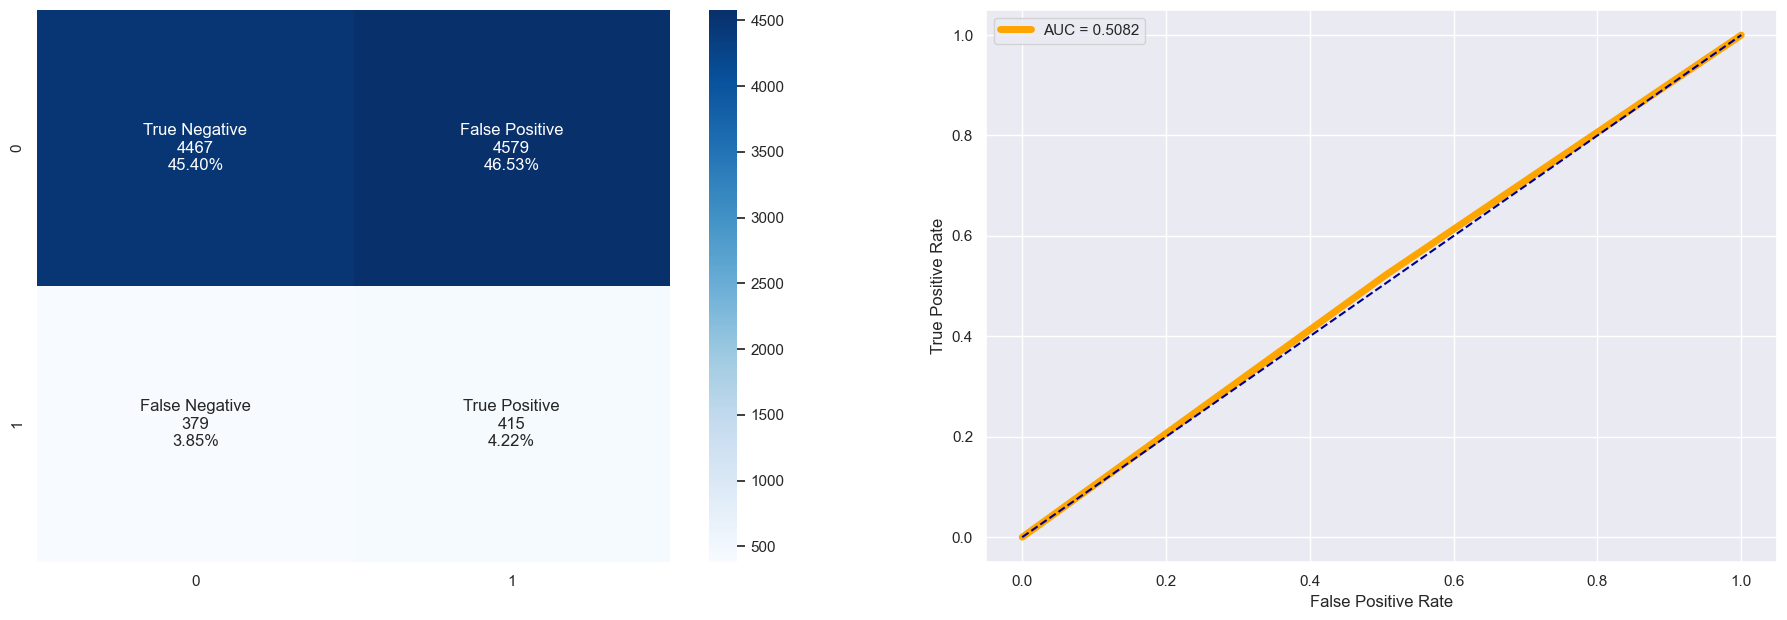

In [27]:
%time
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Compute results 
dc_model, dc_results_cv, dc_results_test = train_model(dc_name, dc, cv=5, fast_train=0.2)

##### Logistical regression (= baseline 1)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

{'fit_time': array([3.01764727, 3.23795581, 3.09926295, 2.56876588, 2.85038304]), 'score_time': array([0.02532077, 0.03519201, 0.03641295, 0.0528791 , 0.02962899]), 'test_accuracy': array([0.86204268, 0.88109756, 0.85530996, 0.87944614, 0.88262195]), 'test_precision': array([0.13570275, 0.14420804, 0.11230769, 0.16163793, 0.15550239]), 'test_recall': array([0.13228346, 0.09606299, 0.11496063, 0.11811024, 0.10220126]), 'test_f1': array([0.13397129, 0.11531191, 0.11361868, 0.13648772, 0.12333966]), 'test_roc_auc': array([0.55398559, 0.54509645, 0.56980021, 0.57121115, 0.54625849]), 'test_specificity': array([0.92607434, 0.94997927, 0.92027083, 0.94624845, 0.95121614]), 'test_fpr': array([-0.07392566, -0.05002073, -0.07972917, -0.05375155, -0.04878386]), 'test_business_score': array([-0.02090193, -0.00758769, -0.05025054,  0.0067287 ,  0.00128645])}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


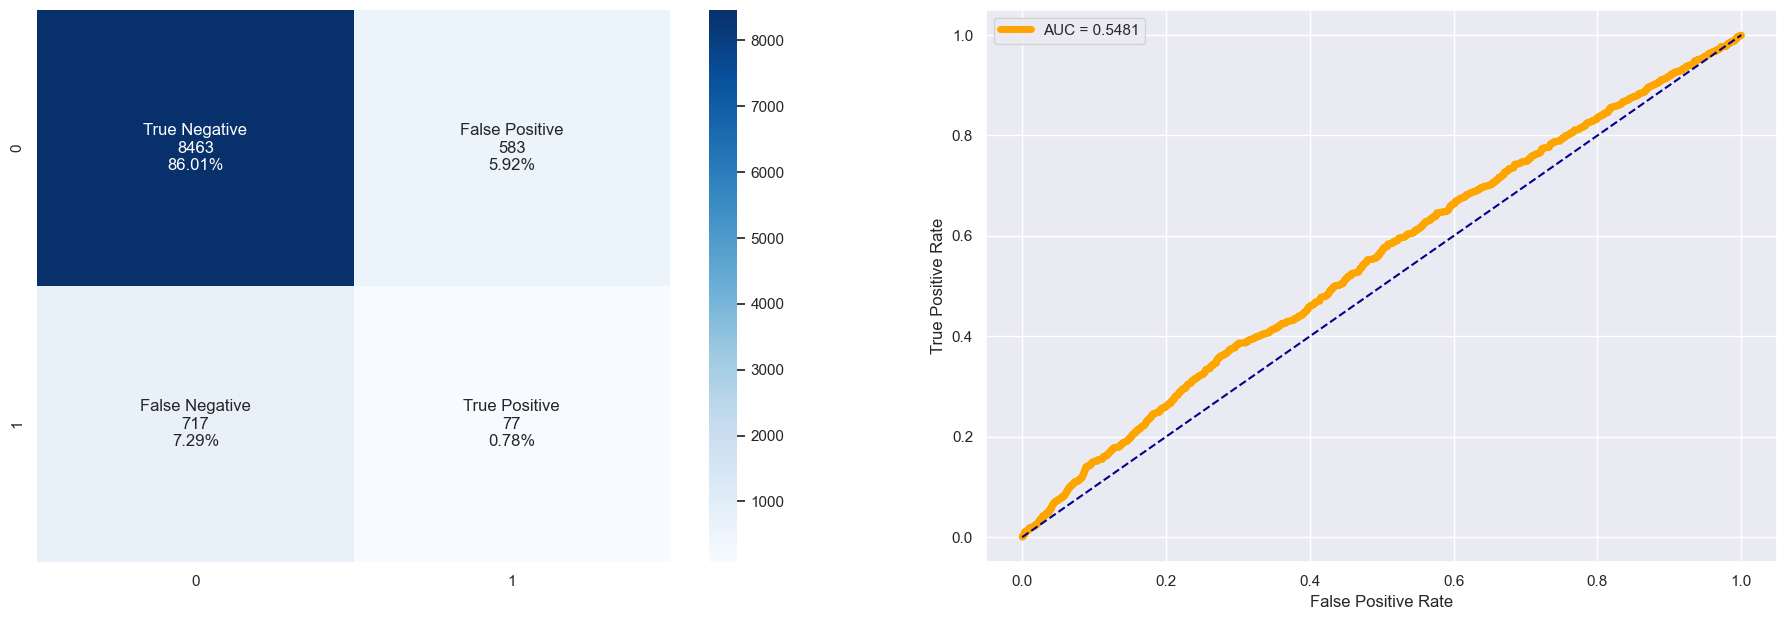

In [28]:
%time
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lr_name = 'LogisticRegression'

# Compute results 
lr_model, lr_results_cv, lr_results_test = train_model(lr_name, lr, cv=5, fast_train=0.2)

##### RandomForest

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
{'fit_time': array([12.82341599, 12.66022301, 12.81453109, 12.89006686, 12.65402818]), 'score_time': array([0.29617906, 0.1925199 , 0.29492211, 0.07727218, 0.19305396]), 'test_accuracy': array([0.91514228, 0.91628557, 0.91653963, 0.9171748 , 0.91590447]), 'test_precision': array([0.2295082 , 0.26      , 0.28      , 0.36507937, 0.27586207]), 'test_recall': array([0.02204724, 0.02047244, 0.02204724, 0.03622047, 0.02515723]), 'test_f1': array([0.04022989, 0.0379562 , 0.04087591, 0.06590258, 0.04610951]), 'test_roc_auc': array([0.68295069, 0.70873247, 0.71891483, 0.71826604, 0.69714321]), 'test_specificity': array([0.9935056 , 0.99488738, 0.99502556, 0.99447285, 0.99419569]), 'test_fpr': array([-0.0064944 , -0.00511262, -0.00497444, -0.00552715, -0.00580431]), 'test_business_score': array([0.00858984, 0.00987831, 0.01173944, 0.02476736, 0.01315037])}


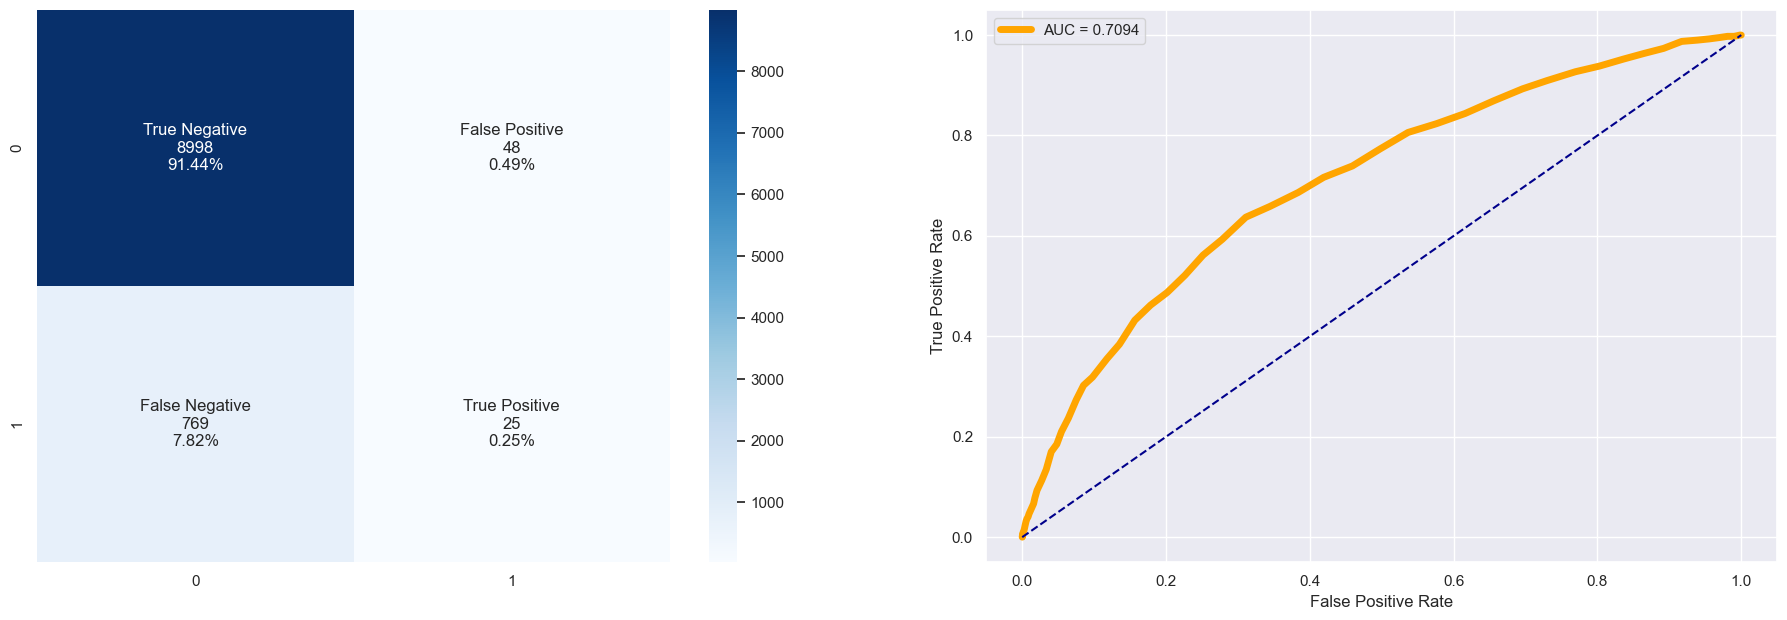

In [29]:
%time
# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_name = 'RandomForest'

# Compute results 
rf_model, rf_results_cv, rf_results_test = train_model(rf_name, rf, cv=5, fast_train=0.2)

##### XGBoost

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:26:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:26:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:26:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:26:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

{'fit_time': array([7.8355341 , 7.98747516, 7.865973  , 7.93018103, 7.91849089]), 'score_time': array([0.11825991, 0.10429001, 0.13322186, 0.11322498, 0.10591412]), 'test_accuracy': array([0.90269309, 0.90193089, 0.90447154, 0.89875508, 0.90027947]), 'test_precision': array([0.29846154, 0.29552239, 0.32432432, 0.27747253, 0.26045016]), 'test_recall': array([0.15275591, 0.15590551, 0.17007874, 0.15905512, 0.12735849]), 'test_f1': array([0.20208333, 0.20412371, 0.2231405 , 0.2022022 , 0.17106653]), 'test_roc_auc': array([0.72827193, 0.72838835, 0.75938827, 0.72937605, 0.70921989]), 'test_specificity': array([0.96849523, 0.9673898 , 0.96890977, 0.96365897, 0.96821448]), 'test_fpr': array([-0.03150477, -0.0326102 , -0.03109023, -0.03634103, -0.03178552]), 'test_business_score': array([0.08747316, 0.08833214, 0.10565497, 0.08375089, 0.06160663])}


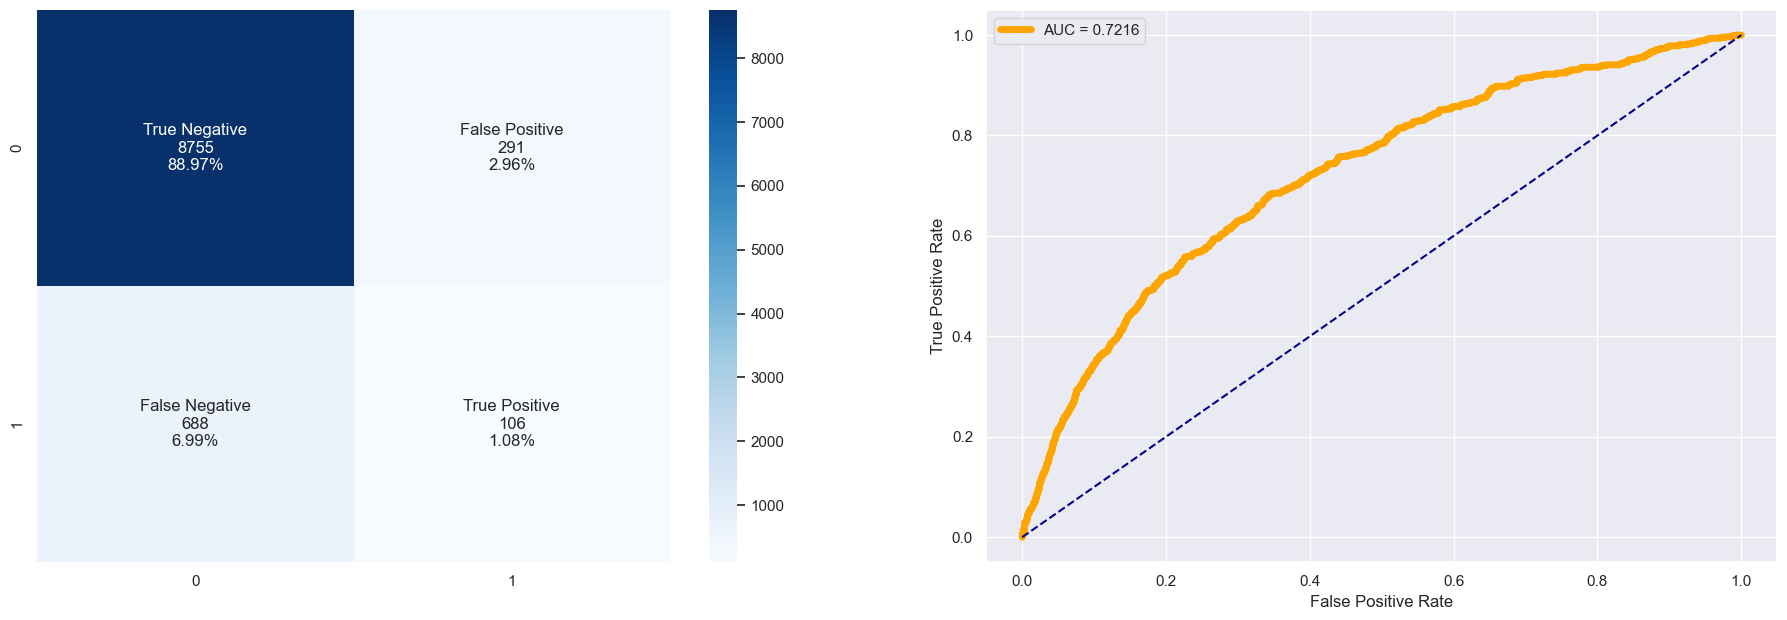

In [30]:
%time
# Create XGBoost classifier
xgbc = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbc_name = 'XGBoost'

# Compute results 
xgbc_model, xgbc_results_cv, xgbc_results_test = train_model(xgbc_name, xgbc, cv=5, fast_train=0.2)

##### LightGBM

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98694
[LightGBM] [Info] Number of data points in the train set: 28946, number of used features: 492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Number of positive: 14474, number of negative: 14474
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

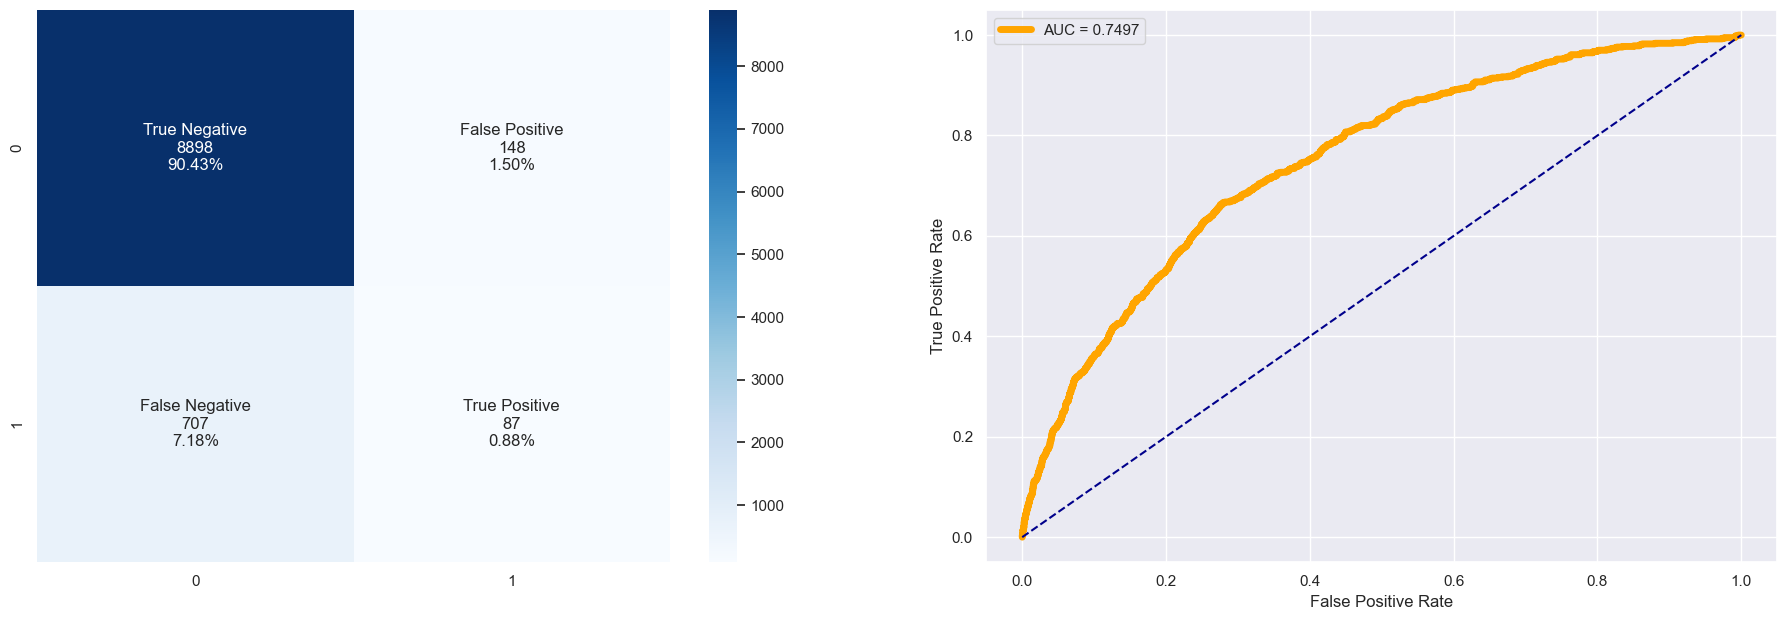

In [32]:
%time
# Create LightGBM classifier
lgbmc = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmc_name = 'LightGBM'

# Compute results 
lgbmc_model, lgbmc_results_cv, lgbmc_results_test = train_model(lgbmc_name, lgbmc, cv=5, fast_train=0.2)

##### CatBoost

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs
Learning rate set to 0.043354
Learning rate set to 0.043354
0:	learn: 0.6425117	total: 249ms	remaining: 4m 8s
Learning rate set to 0.043354
0:	learn: 0.6442072	total: 296ms	remaining: 4m 56s
Learning rate set to 0.043354
Learning rate set to 0.043356
1:	learn: 0.6014886	total: 411ms	remaining: 3m 24s
1:	learn: 0.6062090	total: 347ms	remaining: 2m 53s
2:	learn: 0.5704179	total: 415ms	remaining: 2m 17s
2:	learn: 0.5621788	total: 493ms	remaining: 2m 43s
0:	learn: 0.6549730	total: 212ms	remaining: 3m 31s
3:	learn: 0.5409671	total: 515ms	remaining: 2m 8s
0:	learn: 0.6482080	total: 195ms	remaining: 3m 14s
0:	learn: 0.6430669	total: 214ms	remaining: 3m 33s
3:	learn: 0.5305633	total: 640ms	remaining: 2m 39s
4:	learn: 0.5135678	total: 597ms	remaining: 1m 58s
1:	learn: 0.6015466	total: 300ms	remaining: 2m 29s
1:	learn: 0.6116324	total: 334ms	remaining: 2m 46s
1:	learn: 0.5956299	total: 369ms	remaining: 3m 4s
4:	learn: 0.5036466	tota

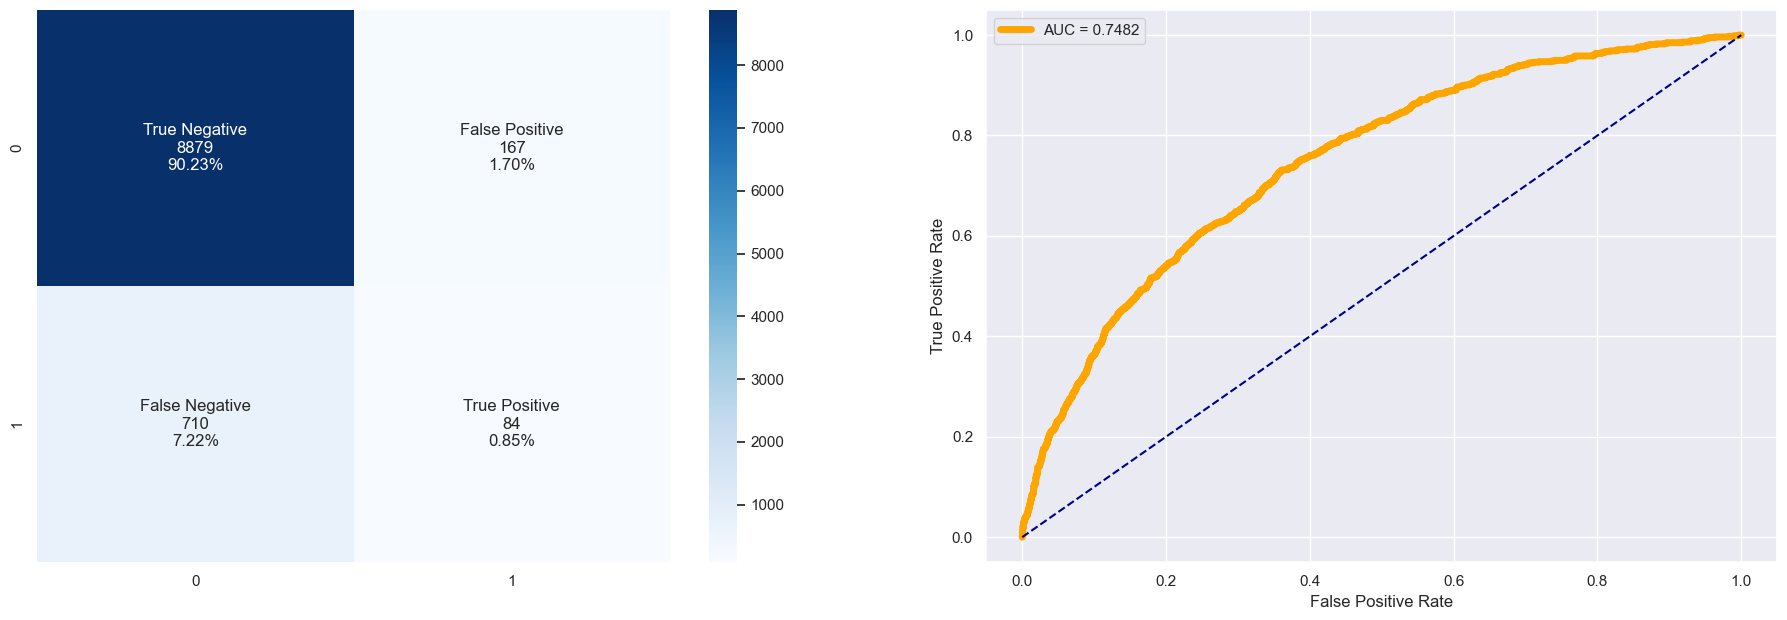

In [34]:
%time
# Create CatBoost classifier
cbc = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbc_name = 'CatBoost'

# Compute results 
cbc_model, cbc_results_cv, cbc_results_test = train_model(cbc_name, cbc, cv=5, fast_train=0.2)

##### Comparison

In [35]:
results_cv = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lr_results_cv, 
    'RandomForest': rf_results_cv,
    'XGBoost': xgbc_results_cv,
    'LightGBM': lgbmc_results_cv,
    'CatBoost': cbc_results_cv
}

pd.DataFrame.from_dict(results_cv)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
accuracy               0.491845            0.872104      0.916209  0.901626   
precision              0.077155            0.141872      0.282090  0.291246   
recall                 0.483318            0.112724      0.025189  0.153031   
f1                     0.133068            0.124546      0.046215  0.200523   
roc_auc                0.487956            0.557270      0.705201  0.730929   
specificity            0.492593            0.938758      0.994417  0.967334   
fpr                   -0.507407           -0.061242     -0.005583 -0.032666   
business_score        -0.567746           -0.014145      0.013625  0.085364   
fit_time               1.407891            2.954803     12.768453  7.907531   
execution_time         2.531519            3.865579     13.858848  8.451669   

                LightGBM    CatBoost  
accuracy        0.912322    0.912779  
precision       0.371827    0.377298  
recall          0.125627    0.124684  
f1              0.187771    0.187409  
roc_auc         0.757741    0.761423  
specificity     0.981373    0.981953  
fpr            -0.018627   -0.018047  
business_score  0.087042    0.087301  
fit_time        8.449713  103.092952  
execution_time  9.025337  103.814294

In [36]:
results_test = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lr_results_test, 
    'RandomForest': rf_results_test,
    'XGBoost': xgbc_results_test,
    'LightGBM': lgbmc_results_test,
    'CatBoost': cbc_results_test
}

pd.DataFrame.from_dict(results_test)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
fit_time               0.708954            2.939388      3.956398  3.083736   
accuracy               0.496138            0.867886      0.916972  0.900508   
precision              0.083100            0.116667      0.342466  0.267003   
recall                 0.522670            0.096977      0.031486  0.133501   
f1                     0.143400            0.105915      0.057670  0.178002   
roc_auc                0.508240            0.548052      0.709392  0.721583   
specificity            0.493809            0.935552      0.994694  0.967831   
fpr                    0.506191            0.064448      0.005306  0.032169   
business_score        -0.525876           -0.036524      0.020495  0.066865   

                LightGBM   CatBoost  
fit_time        2.927170  26.028842  
accuracy        0.913110   0.910874  
precision       0.370213   0.334661  
recall          0.109572   0.105793  
f1              0.169096   0.160766  
roc_auc         0.749690   0.748192  
specificity     0.983639   0.981539  
fpr             0.016361   0.018461  
business_score  0.075681   0.067552

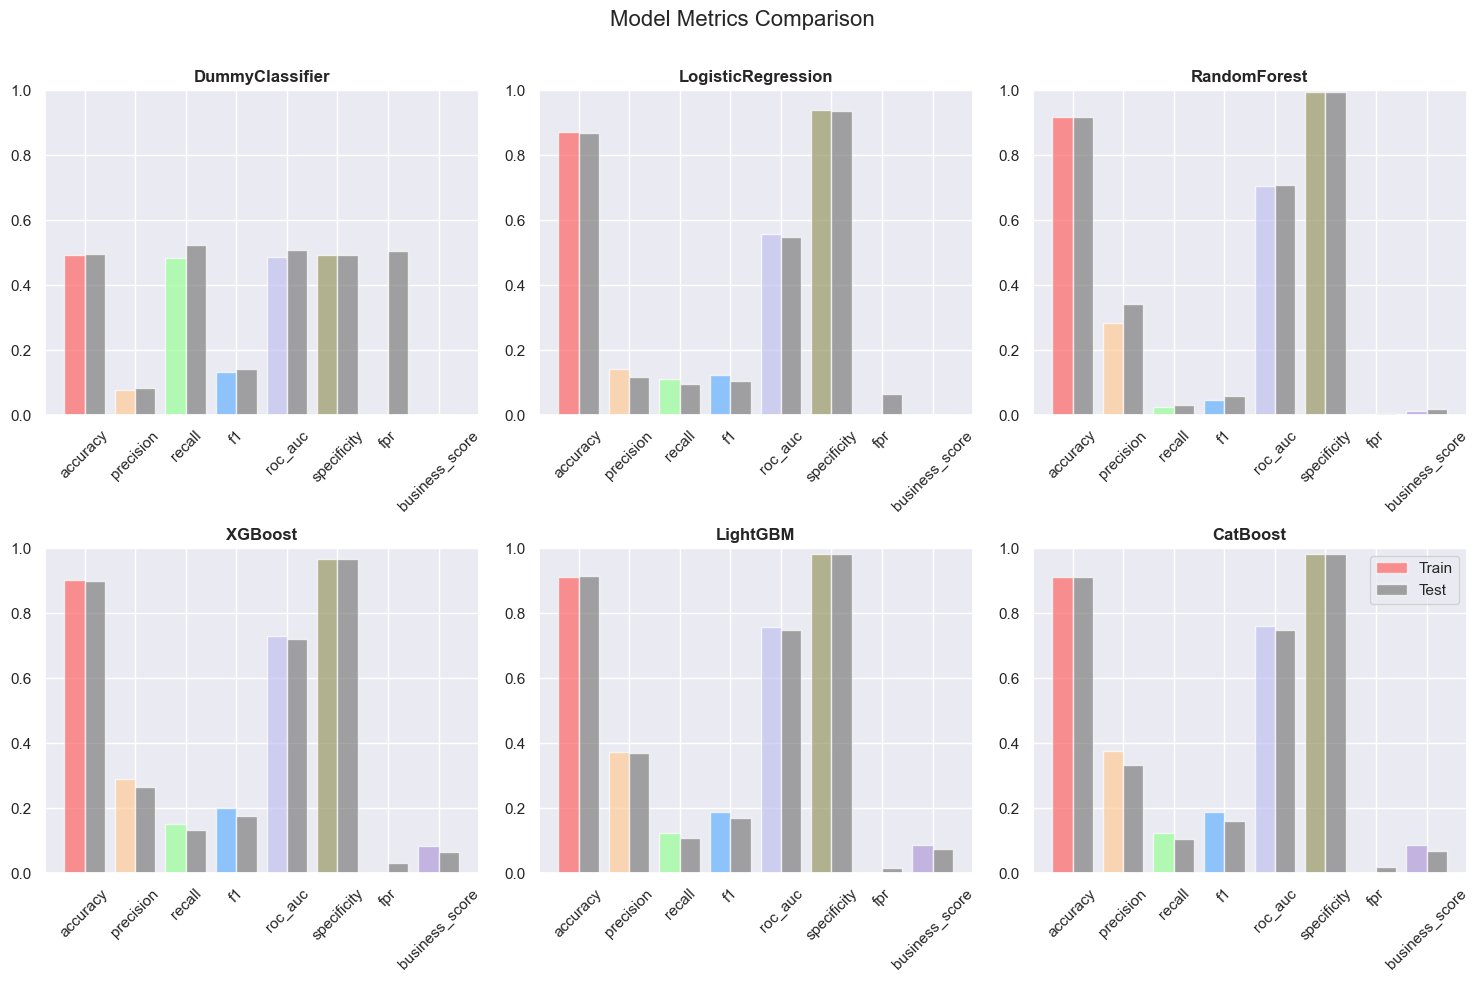

In [37]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv, results_test, metrics)

#### Hyperparameter optimization

For hyperparameter optimization, let's change few things for the sake of computation capacity: 
- Use 20% of total data

##### DummyClassifier (= baseline 0)

Since this one is the baseline 0, it does not need to be optimized.

##### Logistical regression (= baseline 1)

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 7.39 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will 

[CV 2/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.205) business_score: (test=-0.876) f1: (test=0.153) fpr: (test=-0.855) precision: (test=0.084) recall: (test=0.887) roc_auc: (test=0.525) specificity: (test=0.145) total time=  13.9s
[CV 1/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.220) business_score: (test=-0.851) f1: (test=0.154) fpr: (test=-0.838) precision: (test=0.084) recall: (test=0.876) roc_auc: (test=0.522) specificity: (test=0.162) total time=  13.9s
[CV 3/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.211) business_score: (test=-0.865) f1: (test=0.154) fpr: (test=-0.848) precision: (test=0.084) recall: (test=0.884) roc_auc: (test=0.514) specificity: (test=0.152) total time=  13.9s
[CV 2/5] END classifier__C=1, classifier__max_iter=100, classifier__pe

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.211) business_score: (test=-0.865) f1: (test=0.154) fpr: (test=-0.848) precision: (test=0.084) recall: (test=0.884) roc_auc: (test=0.514) specificity: (test=0.152) total time=  14.2s
[CV 1/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.220) business_score: (test=-0.851) f1: (test=0.154) fpr: (test=-0.838) precision: (test=0.084) recall: (test=0.876) roc_auc: (test=0.522) specificity: (test=0.162) total time=  14.4s
[CV 5/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.213) business_score: (test=-0.841) f1: (test=0.157) fpr: (test=-0.848) precision: (test=0.086) recall: (test=0.908) roc_auc: (test=0.555) specificity: (test=0.152) total time=  14.4s
[CV 4/5] END classifier__C=1, classifier__max_iter=100, classifier__penal

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.fra

[CV 1/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.220) business_score: (test=-0.851) f1: (test=0.154) fpr: (test=-0.838) precision: (test=0.084) recall: (test=0.876) roc_auc: (test=0.522) specificity: (test=0.162) total time=  13.3s
[CV 5/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.213) business_score: (test=-0.841) f1: (test=0.157) fpr: (test=-0.848) precision: (test=0.086) recall: (test=0.908) roc_auc: (test=0.555) specificity: (test=0.152) total time=  13.4s
[CV 3/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.211) business_score: (test=-0.865) f1: (test=0.154) fpr: (test=-0.848) precision: (test=0.084) recall: (test=0.884) roc_auc: (test=0.514) specificity: (test=0.152) total time=  13.1s
[CV 4/5] END classifier__C=0.01, classifier__max_iter=100, classifier__pena

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.213) business_score: (test=-0.841) f1: (test=0.157) fpr: (test=-0.848) precision: (test=0.086) recall: (test=0.908) roc_auc: (test=0.555) specificity: (test=0.152) total time=  13.4s
[CV 4/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.197) business_score: (test=-0.885) f1: (test=0.153) fpr: (test=-0.864) precision: (test=0.084) recall: (test=0.897) roc_auc: (test=0.525) specificity: (test=0.136) total time=  13.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.205) business_score: (test=-0.876) f1: (test=0.153) fpr: (test=-0.855) precision: (test=0.084) recall: (test=0.887) roc_auc: (test=0.525) specificity: (test=0.145) total time=  14.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 1/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.876) business_score: (test=0.003) f1: (test=0.137) fpr: (test=-0.058) precision: (test=0.157) recall: (test=0.122) roc_auc: (test=0.572) specificity: (test=0.942) total time=   3.2s
[CV 3/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.874) business_score: (test=-0.005) f1: (test=0.130) fpr: (test=-0.059) precision: (test=0.148) recall: (test=0.116) roc_auc: (test=0.563) specificity: (test=0.941) total time=   2.7s
[CV 2/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.869) business_score: (test=0.000) f1: (test=0.145) fpr: (test=-0.066) precision: (test=0.154) recall: (test=0.136) roc_auc: (test=0.588) specificity: (test=0.934) total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.28604e-24): result may not be accurate.
  warnings.warn(


[CV 5/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.876) business_score: (test=-0.014) f1: (test=0.117) fpr: (test=-0.056) precision: (test=0.138) recall: (test=0.102) roc_auc: (test=0.573) specificity: (test=0.944) total time=   2.3s
[CV 4/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.871) business_score: (test=-0.017) f1: (test=0.121) fpr: (test=-0.062) precision: (test=0.136) recall: (test=0.110) roc_auc: (test=0.538) specificity: (test=0.938) total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.48015e-24): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the fi

[CV 1/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.795) business_score: (test=-0.106) f1: (test=0.142) fpr: (test=-0.153) precision: (test=0.108) recall: (test=0.210) roc_auc: (test=0.571) specificity: (test=0.847) total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.37088e-24

[CV 3/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.843) business_score: (test=-0.047) f1: (test=0.135) fpr: (test=-0.096) precision: (test=0.122) recall: (test=0.150) roc_auc: (test=0.567) specificity: (test=0.904) total time=  10.1s
[CV 2/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.836) business_score: (test=-0.066) f1: (test=0.127) fpr: (test=-0.104) precision: (test=0.111) recall: (test=0.147) roc_auc: (test=0.573) specificity: (test=0.896) total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.50545e-24): result may not be accurate.
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.876) business_score: (test=0.003) f1: (test=0.137) fpr: (test=-0.058) precision: (test=0.157) recall: (test=0.122) roc_auc: (test=0.572) specificity: (test=0.942) total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.869) business_score: (test=0.000) f1: (test=0.145) fpr: (test=-0.066) precision: (test=0.154) recall: (test=0.136) roc_auc: (test=0.588) specificity: (test=0.934) total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.855) business_score: (test=-0.052) f1: (test=0.111) fpr: (test=-0.079) precision: (test=0.110) recall: (test=0.111) roc_auc: (test=0.546) specificity: (test=0.921) total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.874) business_score: (test=-0.005) f1: (test=0.130) fpr: (test=-0.059) precision: (test=0.148) recall: (test=0.116) roc_auc: (test=0.563) specificity: (test=0.941) total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.839) business_score: (test=-0.049) f1: (test=0.138) fpr: (test=-0.101) precision: (test=0.122) recall: (test=0.160) roc_auc: (test=0.589) specificity: (test=0.899) total time=   9.8s
[CV 4/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.871) business_score: (test=-0.017) f1: (test=0.121) fpr: (test=-0.062) precision: (test=0.136) recall: (test=0.110) roc_auc: (test=0.538) specificity: (test=0.938) total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.876) business_score: (test=-0.014) f1: (test=0.117) fpr: (test=-0.056) precision: (test=0.138) recall: (test=0.102) roc_auc: (test=0.573) specificity: (test=0.944) total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ign

[CV 1/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.847) business_score: (test=-0.059) f1: (test=0.116) fpr: (test=-0.089) precision: (test=0.110) recall: (test=0.124) roc_auc: (test=0.574) specificity: (test=0.911) total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.860) business_score: (test=-0.020) f1: (test=0.138) fpr: (test=-0.077) precision: (test=0.137) recall: (test=0.138) roc_auc: (test=0.594) specificity: (test=0.923) total time=  10.2s
[CV 2/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.824) business_score: (test=-0.089) f1: (test=0.123) fpr: (test=-0.117) precision: (test=0.103) recall: (test=0.152) roc_auc: (test=0.578) specificity: (test=0.883) total time=  10.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 4/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.851) business_score: (test=-0.060) f1: (test=0.110) fpr: (test=-0.084) precision: (test=0.106) recall: (test=0.113) roc_auc: (test=0.544) specificity: (test=0.916) total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.846) business_score: (test=-0.041) f1: (test=0.136) fpr: (test=-0.092) precision: (test=0.125) recall: (test=0.149) roc_auc: (test=0.583) specificity: (test=0.908) total time=   8.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 1/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.226) business_score: (test=-0.841) f1: (test=0.155) fpr: (test=-0.831) precision: (test=0.085) recall: (test=0.873) roc_auc: (test=0.526) specificity: (test=0.169) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.207) business_score: (test=-0.873) f1: (test=0.153) fpr: (test=-0.852) precision: (test=0.084) recall: (test=0.884) roc_auc: (test=0.530) specificity: (test=0.148) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.212) business_score: (test=-0.869) f1: (test=0.153) fpr: (test=-0.847) precision: (test=0.084) recall: (test=0.876) roc_auc: (test=0.519) specificity: (test=0.153) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra

[CV 1/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.227) business_score: (test=-0.840) f1: (test=0.154) fpr: (test=-0.830) precision: (test=0.085) recall: (test=0.871) roc_auc: (test=0.529) specificity: (test=0.170) total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.00662e-26

[CV 1/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.827) business_score: (test=-0.079) f1: (test=0.127) fpr: (test=-0.114) precision: (test=0.107) recall: (test=0.155) roc_auc: (test=0.570) specificity: (test=0.886) total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.62617e-26): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_i

[CV 2/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.828) business_score: (test=-0.079) f1: (test=0.126) fpr: (test=-0.113) precision: (test=0.107) recall: (test=0.154) roc_auc: (test=0.578) specificity: (test=0.887) total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.842) business_score: (test=-0.042) f1: (test=0.141) fpr: (test=-0.098) precision: (test=0.126) recall: (test=0.160) roc_auc: (test=0.568) specificity: (test=0.902) total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.79241e-26): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the fi

[CV 4/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.200) business_score: (test=-0.880) f1: (test=0.154) fpr: (test=-0.861) precision: (test=0.084) recall: (test=0.895) roc_auc: (test=0.528) specificity: (test=0.139) total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.208) business_score: (test=-0.872) f1: (test=0.153) fpr: (test=-0.852) precision: (test=0.084) recall: (test=0.884) roc_auc: (test=0.532) specificity: (test=0.148) total time= 2.1min
[CV 3/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.213) business_score: (test=-0.866) f1: (test=0.153) fpr: (test=-0.845) precision: (test=0.084) recall: (test=0.876) roc_auc: (test=0.523) specificity: (test=0.155) total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.215) business_score: (test=-0.836) f1: (test=0.158) fpr: (test=-0.846) precision: (test=0.086) recall: (test=0.908) roc_auc: (test=0.561) specificity: (test=0.154) total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.838) business_score: (test=-0.078) f1: (test=0.113) fpr: (test=-0.099) precision: (test=0.101) recall: (test=0.127) roc_auc: (test=0.540) specificity: (test=0.901) total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.841) business_score: (test=-0.050) f1: (test=0.134) fpr: (test=-0.098) precision: (test=0.120) recall: (test=0.152) roc_auc: (test=0.589) specificity: (test=0.902) total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.200) business_score: (test=-0.881) f1: (test=0.153) fpr: (test=-0.861) precision: (test=0.084) recall: (test=0.895) roc_auc: (test=0.527) specificity: (test=0.139) total time=  50.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.215) business_score: (test=-0.837) f1: (test=0.158) fpr: (test=-0.846) precision: (test=0.086) recall: (test=0.908) roc_auc: (test=0.559) specificity: (test=0.154) total time=  47.9s


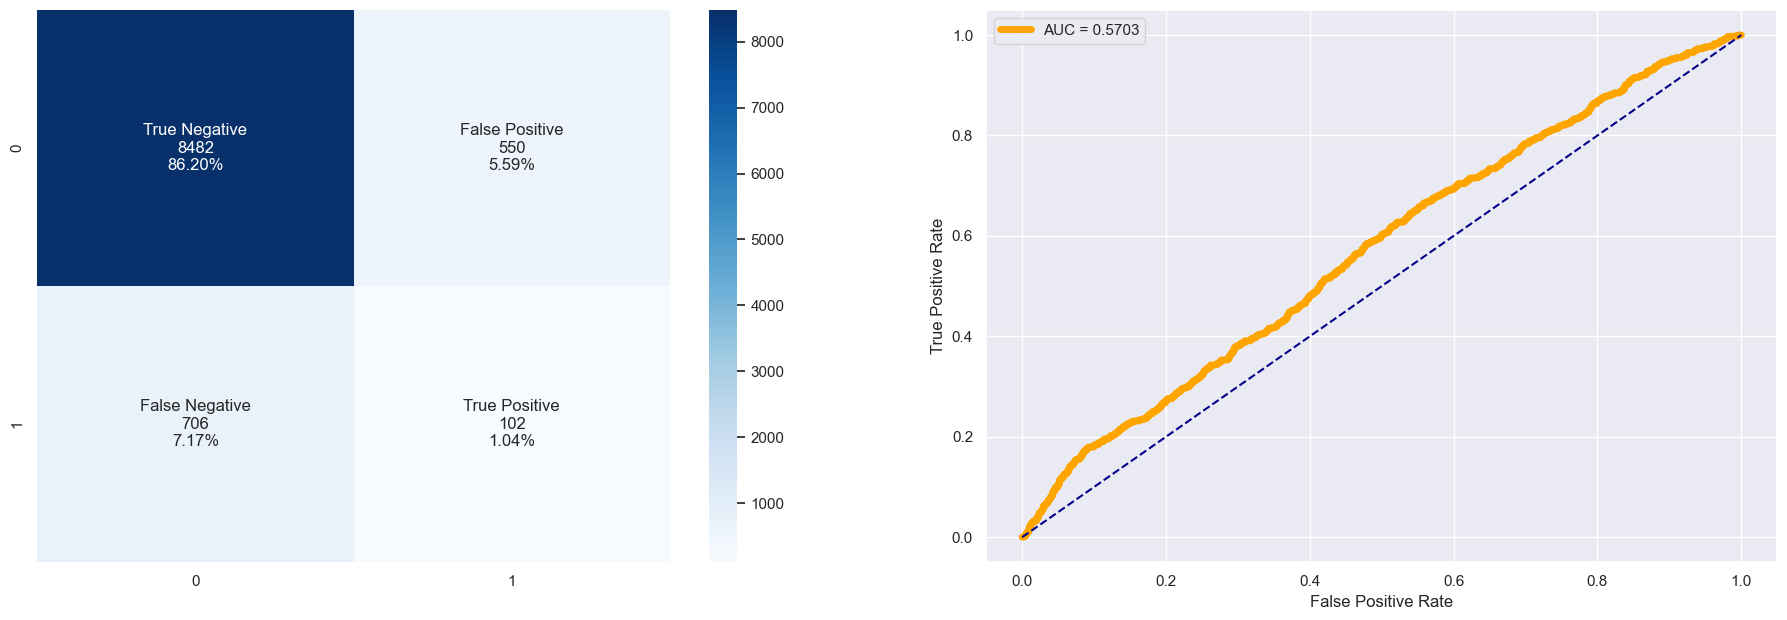

In [38]:
%time
# Create logistic regression model
lrt = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lrt_name = 'LogisticRegression_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l2', 'none'],  # Regularization penalty --> only use l2 due to one-hot encode
    'classifier__solver': ['lbfgs', 'saga', 'newton-cholesky'],  # Solver options
    'classifier__max_iter': [100, 500, 1000],  # Maximum iterations
}

# Compute results and get fine-tuned model
lrt_model, lrt_results_cv, lrt_results_test = search_hyperparameters(lrt_name, lrt, param_grid=param_grid, cv=5, fast_train=0.2)

##### RandomForest

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (test=nan) roc_auc: (test=nan) specificity: (test=nan) total time=   2.1s
[CV 5/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (test=nan) roc_auc: (test=nan) specificity: (test=nan) total time=   2.1s
[CV 3/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (

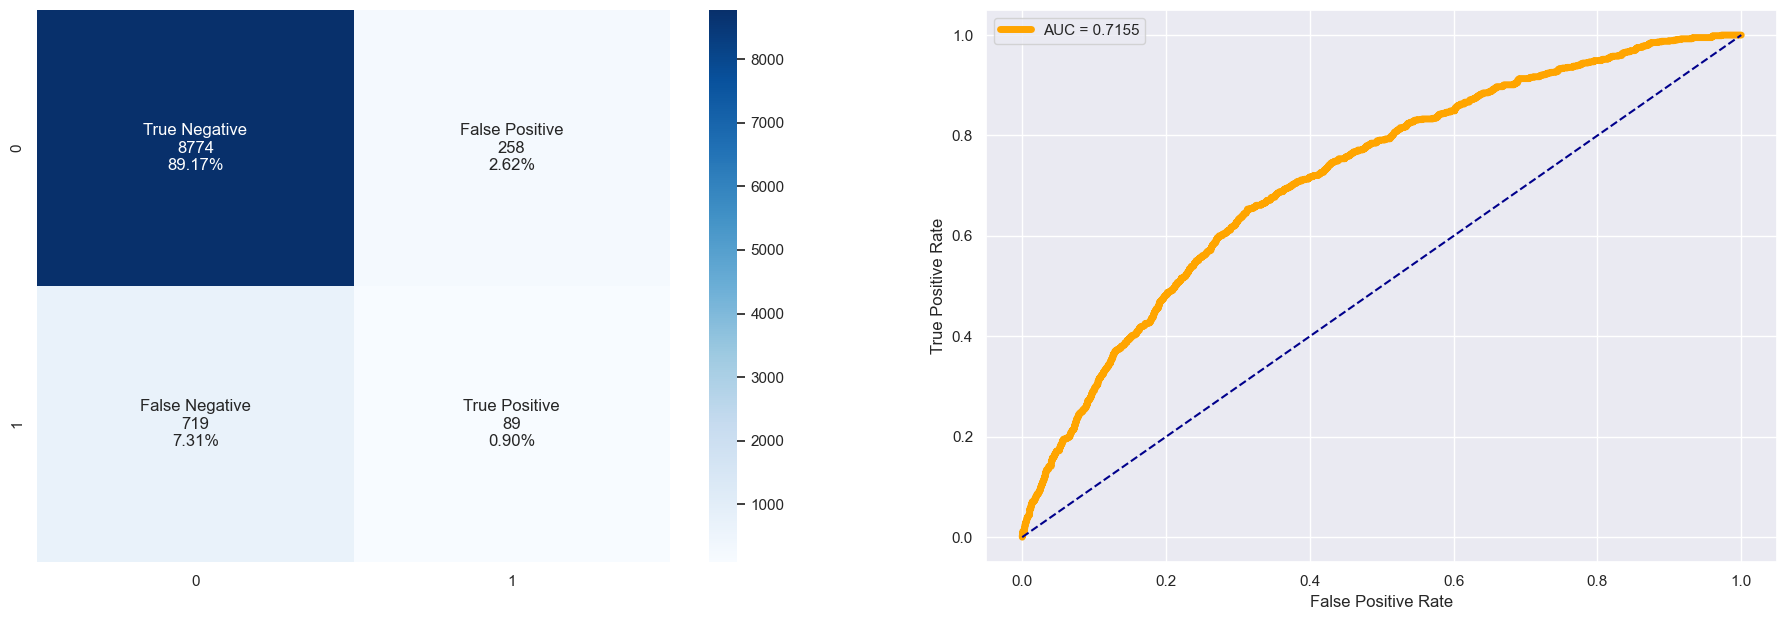

In [39]:
%time
# Create random forest classifier
rft = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rft_name = 'RandomForest_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt'],
}

# Compute results and get fine-tuned model
rft_model, rft_results_cv, rft_results_test = search_hyperparameters(rft_name, rft, param_grid=param_grid, cv=5, fast_train=0.2)

##### XGBoost

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.886) business_score: (test=0.036) f1: (test=0.161) fpr: (test=-0.048) precision: (test=0.200) recall: (test=0.135) roc_auc: (test=0.680) specificity: (test=0.952) total time=   7.1s
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.892) business_score: (test=0.037) f1: (test=0.153) fpr: (test=-0.040) precision: (test=0.209) recall: (test=0.121) roc_auc: (test=0.671) specificity: (test=0.960) total time=   7.3s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.893) business_score: (test=0.036) f1: (test=0.149) fpr: (test=-0.039) precision: (test=0.209) recall: (test=0.116) roc_auc: (test=0.659) specificity: (test=0.961) total time=   7.3s
[CV 5/5] END classifie

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.884) business_score: (test=0.008) f1: (test=0.128) fpr: (test=-0.047) precision: (test=0.164) recall: (test=0.105) roc_auc: (test=0.657) specificity: (test=0.953) total time=   6.0s
[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.889) business_score: (test=0.039) f1: (test=0.160) fpr: (test=-0.044) precision: (test=0.207) recall: (test=0.130) roc_auc: (test=0.661) specificity: (test=0.956) total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.912) business_score: (test=0.051) f1: (test=0.129) fpr: (test=-0.014) precision: (test=0.331) recall: (test=0.080) roc_auc: (test=0.751) specificity: (test=0.986) total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.913) business_score: (test=0.070) f1: (test=0.160) fpr: (test=-0.015) precision: (test=0.369) recall: (test=0.102) roc_auc: (test=0.754) specificity: (test=0.985) total time=   7.5s
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.916) business_score: (test=0.050) f1: (test=0.118) fpr: (test=-0.009) precision: (test=0.404) recall: (test=0.069) roc_auc: (test=0.749) specificity: (test=0.991) total time=   7.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.913) business_score: (test=0.037) f1: (test=0.104) fpr: (test=-0.012) precision: (test=0.308) recall: (test=0.063) roc_auc: (test=0.724) specificity: (test=0.988) total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.916) business_score: (test=0.058) f1: (test=0.132) fpr: (test=-0.010) precision: (test=0.410) recall: (test=0.078) roc_auc: (test=0.733) specificity: (test=0.990) total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.912) business_score: (test=0.025) f1: (test=0.083) fpr: (test=-0.011) precision: (test=0.274) recall: (test=0.049) roc_auc: (test=0.736) specificity: (test=0.989) total time=  30.5s
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.913) business_score: (test=0.042) f1: (test=0.112) fpr: (test=-0.012) precision: (test=0.326) recall: (test=0.067) roc_auc: (test=0.723) specificity: (test=0.988) total time=  17.1s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.029) f1: (test=0.080) fpr: (test=-0.008) precision: (test=0.333) recall: (test=0.045) roc_auc: (test=0.723) specificity: (test=0.992) total time=  31.4s
[CV 2/5] END classif

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.054) f1: (test=0.129) fpr: (test=-0.012) precision: (test=0.370) recall: (test=0.078) roc_auc: (test=0.718) specificity: (test=0.988) total time=  32.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.914) business_score: (test=0.015) f1: (test=0.056) fpr: (test=-0.008) precision: (test=0.256) recall: (test=0.031) roc_auc: (test=0.699) specificity: (test=0.992) total time=  32.7s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.911) business_score: (test=0.036) f1: (test=0.107) fpr: (test=-0.014) precision: (test=0.290) recall: (test=0.066) roc_auc: (test=0.721) specificity: (test=0.986) total time=  18.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.914) business_score: (test=0.024) f1: (test=0.076) fpr: (test=-0.010) precision: (test=0.286) recall: (test=0.044) roc_auc: (test=0.710) specificity: (test=0.990) total time=  17.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.914) business_score: (test=0.030) f1: (test=0.086) fpr: (test=-0.010) precision: (test=0.311) recall: (test=0.050) roc_auc: (test=0.724) specificity: (test=0.990) total time=   6.1s
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.911) business_score: (test=0.040) f1: (test=0.114) fpr: (test=-0.015) precision: (test=0.298) recall: (test=0.071) roc_auc: (test=0.728) specificity: (test=0.985) total time=   6.3s
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.917) business_score: (test=0.029) f1: (test=0.074) fpr: (test=-0.006) precision: (test=0.394) recall: (test=0.041) roc_auc: (test=0.724) specificity: (test=0.994) total time=   6.3s
[CV 4/5] END classifier__

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.914) business_score: (test=0.038) f1: (test=0.101) fpr: (test=-0.010) precision: (test=0.336) recall: (test=0.060) roc_auc: (test=0.714) specificity: (test=0.990) total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.910) business_score: (test=0.036) f1: (test=0.110) fpr: (test=-0.016) precision: (test=0.277) recall: (test=0.069) roc_auc: (test=0.704) specificity: (test=0.984) total time=   9.1s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.904) business_score: (test=0.038) f1: (test=0.127) fpr: (test=-0.024) precision: (test=0.244) recall: (test=0.086) roc_auc: (test=0.706) specificity: (test=0.976) total time=   9.5s
[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.912) business_score: (test=0.028) f1: (test=0.087) fpr: (test=-0.012) precision: (test=0.280) recall: (test=0.052) roc_auc: (test=0.692) specificity: (test=0.988) total time=  18.5s
[CV 3/5] END classifie

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.897) business_score: (test=0.046) f1: (test=0.155) fpr: (test=-0.034) precision: (test=0.232) recall: (test=0.116) roc_auc: (test=0.683) specificity: (test=0.966) total time=   7.9s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.892) business_score: (test=0.031) f1: (test=0.143) fpr: (test=-0.039) precision: (test=0.202) recall: (test=0.111) roc_auc: (test=0.691) specificity: (test=0.961) total time=   7.9s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.899) business_score: (test=0.027) f1: (test=0.124) fpr: (test=-0.029) precision: (test=0.209) recall: (test=0.088) roc_auc: (test=0.674) specificity: (test=0.971) total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.900) business_score: (test=0.107) f1: (test=0.229) fpr: (test=-0.037) precision: (test=0.303) recall: (test=0.183) roc_auc: (test=0.738) specificity: (test=0.963) total time=  20.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.892) business_score: (test=0.022) f1: (test=0.131) fpr: (test=-0.038) precision: (test=0.188) recall: (test=0.100) roc_auc: (test=0.671) specificity: (test=0.962) total time=   7.9s
[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.896) business_score: (test=0.037) f1: (test=0.144) fpr: (test=-0.035) precision: (test=0.216) recall: (test=0.108) roc_auc: (test=0.678) specificity: (test=0.965) total time=   8.2s
[CV 2/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.902) business_score: (test=0.095) f1: (test=0.212) fpr: (test=-0.033) precision: (test=0.305) recall: (test=0.163) roc_auc: (test=0.726) specificity: (test=0.967) total time=  20.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.903) business_score: (test=0.098) f1: (test=0.214) fpr: (test=-0.032) precision: (test=0.312) recall: (test=0.163) roc_auc: (test=0.736) specificity: (test=0.968) total time=  20.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.899) business_score: (test=0.058) f1: (test=0.167) fpr: (test=-0.033) precision: (test=0.252) recall: (test=0.125) roc_auc: (test=0.709) specificity: (test=0.967) total time=  20.6s
[CV 5/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.903) business_score: (test=0.108) f1: (test=0.228) fpr: (test=-0.033) precision: (test=0.318) recall: (test=0.177) roc_auc: (test=0.726) specificity: (test=0.967) total time=  20.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:37:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.915) business_score: (test=0.026) f1: (test=0.075) fpr: (test=-0.008) precision: (test=0.325) recall: (test=0.042) roc_auc: (test=0.717) specificity: (test=0.992) total time=  13.7s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.910) business_score: (test=0.028) f1: (test=0.095) fpr: (test=-0.015) precision: (test=0.261) recall: (test=0.058) roc_auc: (test=0.719) specificity: (test=0.985) total time=  12.6s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.917) business_score: (test=0.022) f1: (test=0.060) fpr: (test=-0.006) precision: (test=0.344) recall: (test=0.033) roc_auc: (test=0.710) specificity: (test=0.994) total time=  11.0s
[CV 4/5] END classi

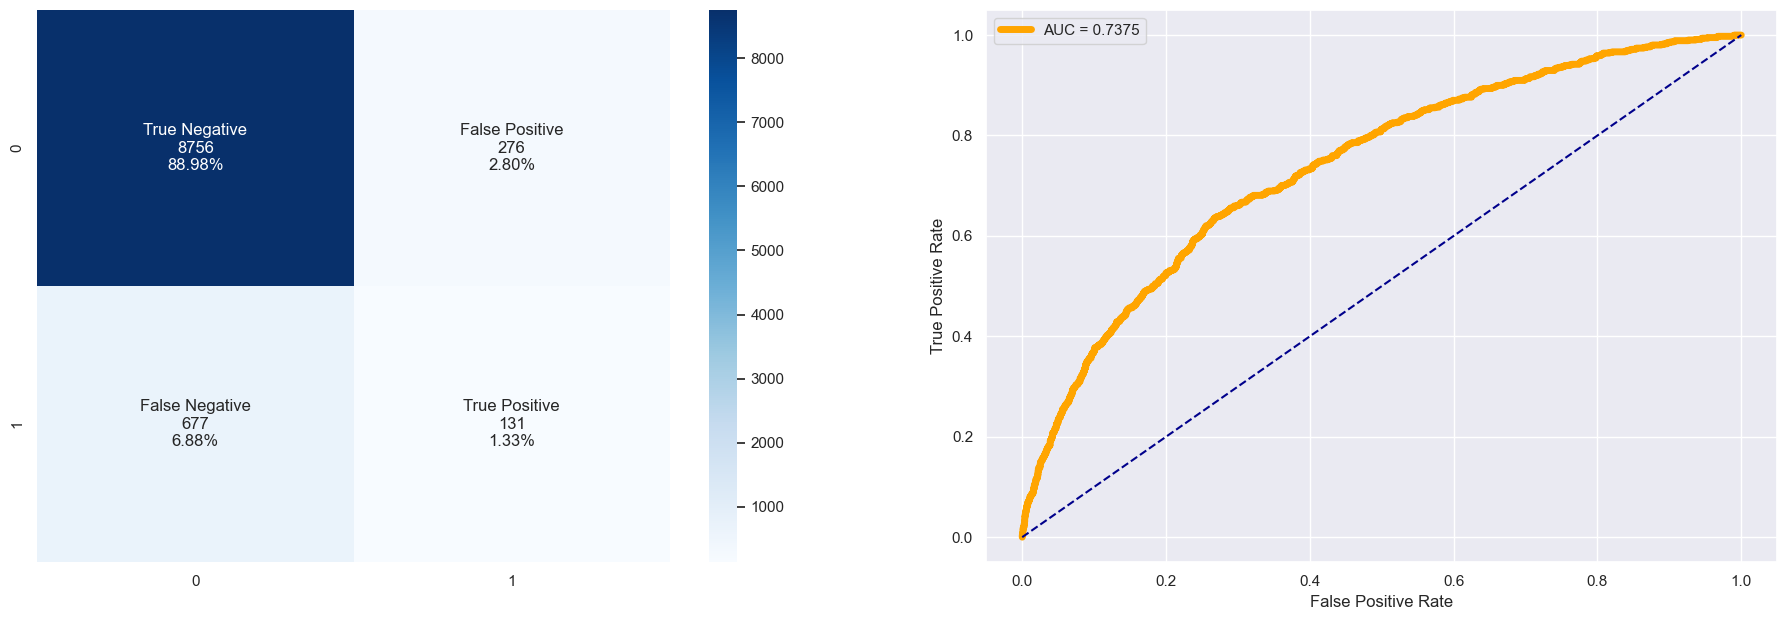

In [40]:
%time
# Create XGBoost classifier
xgbct = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbct_name = 'XGBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
xgbct_model, xgbct_results_cv, xgbct_results_test = search_hyperparameters(xgbct_name, xgbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### LightGBM

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98741
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14

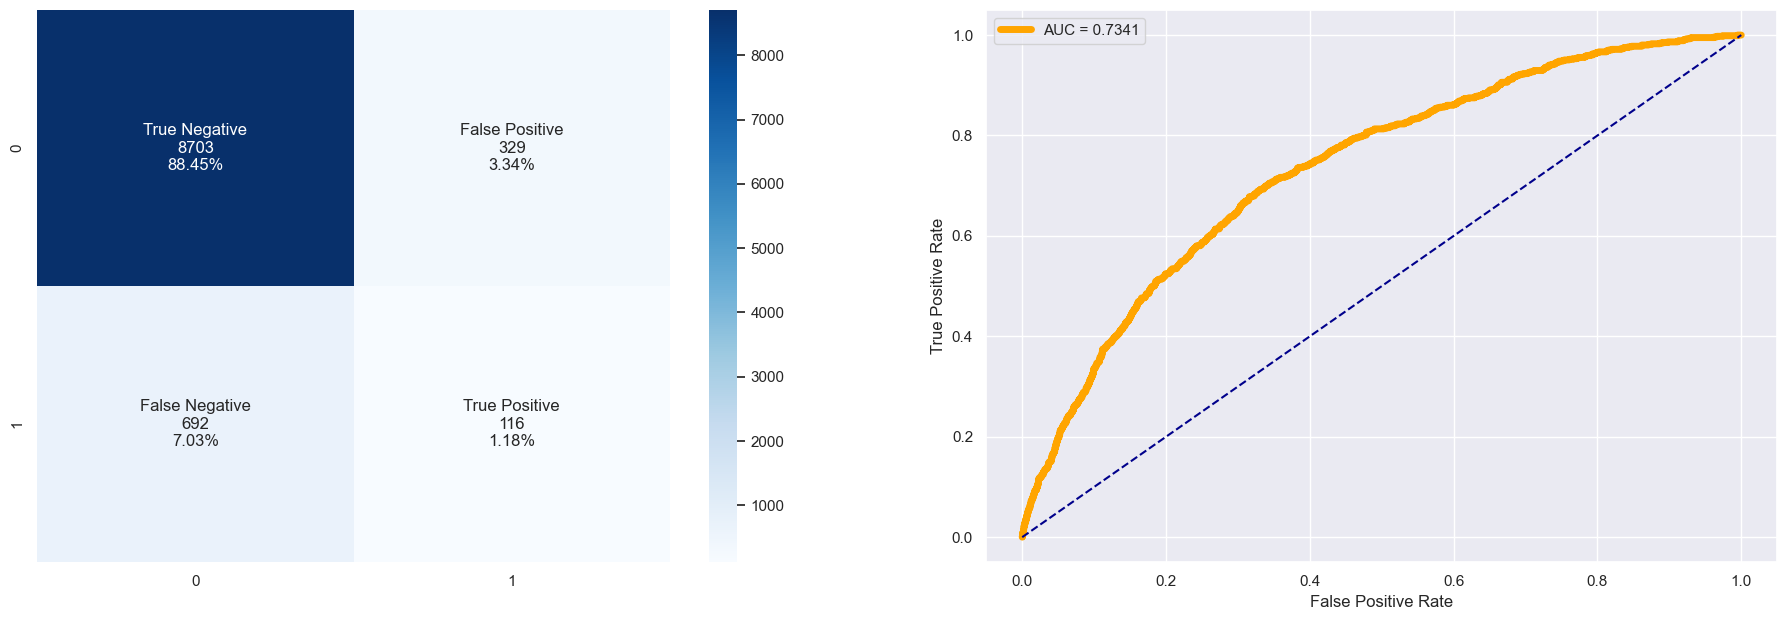

In [41]:
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3 , 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2)

##### CatBoost

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.5790031	total: 433ms	remaining: 21.2s
0:	learn: 0.5913123	total: 543ms	remaining: 26.6s
0:	learn: 0.6811891	total: 379ms	remaining: 18.6s
0:	learn: 0.5882453	total: 628ms	remaining: 30.8s
0:	learn: 0.5788909	total: 650ms	remaining: 31.9s
1:	learn: 0.5243114	total: 1.05s	remaining: 25.3s
1:	learn: 0.6712351	total: 750ms	remaining: 18s
1:	learn: 0.5092705	total: 1.01s	remaining: 24.2s
0:	learn: 0.6818793	total: 439ms	remaining: 21.5s
0:	learn: 0.6807793	total: 317ms	remaining: 15.5s
1:	learn: 0.5196061	total: 1.18s	remaining: 28.3s
2:	learn: 0.6582821	total: 1.1s	remaining: 17.2s
2:	learn: 0.4687992	total: 1.5s	remaining: 23.5s
1:	learn: 0.6706641	total: 712ms	remaining: 17.1s
1:	learn: 0.5024609	total: 1.16s	remaining: 27.9s
1:	learn: 0.6688044	total: 628ms	remaining: 15.1s
2:	learn: 0.4563347	total: 1.52s	remaining: 23.8s
2:	learn: 0.6594557	t

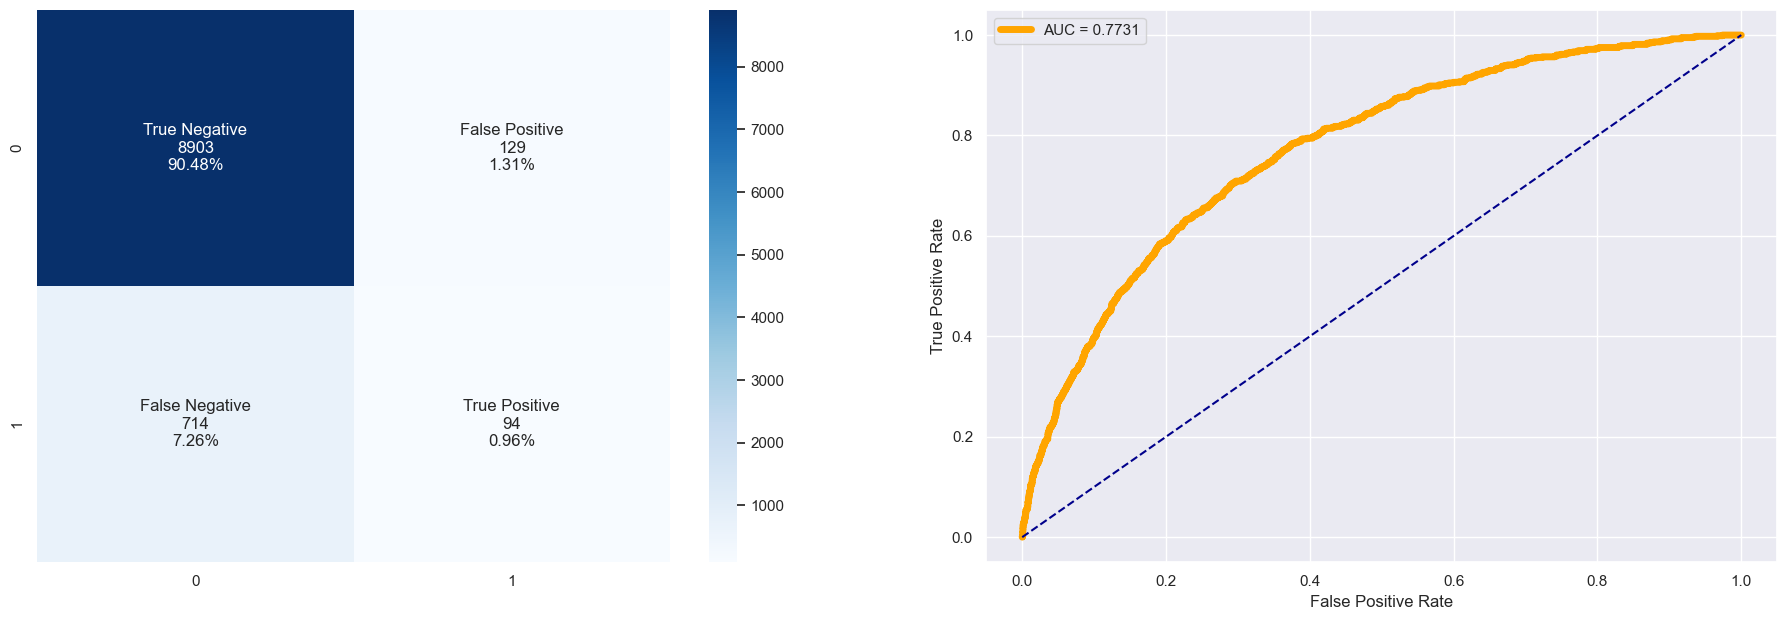

In [42]:
%time
# Create CatBoost classifier
cbct = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbct_name = 'CatBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__iterations': [50, 100, 200],
    'classifier__depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0],  
}

# Compute results and get fine-tuned model
cbct_model, cbct_results_cv, cbct_results_test = search_hyperparameters(cbct_name, cbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### Comparison

In [43]:
results_cv_tuned = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lrt_results_cv, 
    'RandomForest': rft_results_cv,
    'XGBoost': xgbct_results_cv,
    'LightGBM': lgbmct_results_cv,
    'CatBoost': cbct_results_cv
}

pd.DataFrame.from_dict(results_cv_tuned)

DummyClassifier  LogisticRegression  RandomForest    XGBoost  \
accuracy               0.491845            0.873196      0.903709   0.901245   
precision              0.077155            0.146510      0.259560   0.298058   
recall                 0.483318            0.117241      0.100627   0.162382   
f1                     0.133068            0.130137      0.144676   0.210029   
roc_auc                0.487956            0.566690      0.704212   0.726925   
specificity            0.492593            0.939867      0.974537   0.966409   
fpr                   -0.507407           -0.060133     -0.025463  -0.033591   
business_score        -0.567746           -0.006726      0.048133   0.093132   
fit_time               1.407891                 NaN           NaN        NaN   
execution_time         2.531519                 NaN           NaN        NaN   
search_time                 NaN          185.826880     95.428537  91.422142   

                 LightGBM    CatBoost  
accuracy         0.901702    0.913872  
precision        0.299041    0.391467  
recall           0.158621    0.112539  
f1               0.206994    0.174719  
roc_auc          0.722694    0.752480  
specificity      0.967238    0.984545  
fpr             -0.032762   -0.015455  
business_score   0.091080    0.080678  
fit_time              NaN         NaN  
execution_time        NaN         NaN  
search_time     62.813462  255.146489

In [44]:
results_test_tuned = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lrt_results_test, 
    'RandomForest': rft_results_test,
    'XGBoost': xgbct_results_test,
    'LightGBM': lgbmct_results_test,
    'CatBoost': cbct_results_test
}

pd.DataFrame.from_dict(results_test_tuned)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
fit_time               0.708954                 NaN           NaN       NaN   
accuracy               0.496138            0.872358      0.900711  0.903150   
precision              0.083100            0.156442      0.256484  0.321867   
recall                 0.522670            0.126238      0.110149  0.162129   
f1                     0.143400            0.139726      0.154113  0.215638   
roc_auc                0.508240            0.570308      0.715521  0.737526   
specificity            0.493809            0.939105      0.971435  0.969442   
fpr                    0.506191            0.060895      0.028565  0.030558   
business_score        -0.525876            0.002475      0.052093  0.100023   

                LightGBM  CatBoost  
fit_time             NaN       NaN  
accuracy        0.896240  0.914329  
precision       0.260674  0.421525  
recall          0.143564  0.116337  
f1              0.185156  0.182347  
roc_auc         0.734068  0.773057  
specificity     0.963574  0.985717  
fpr             0.036426  0.014283  
business_score  0.069532  0.087309

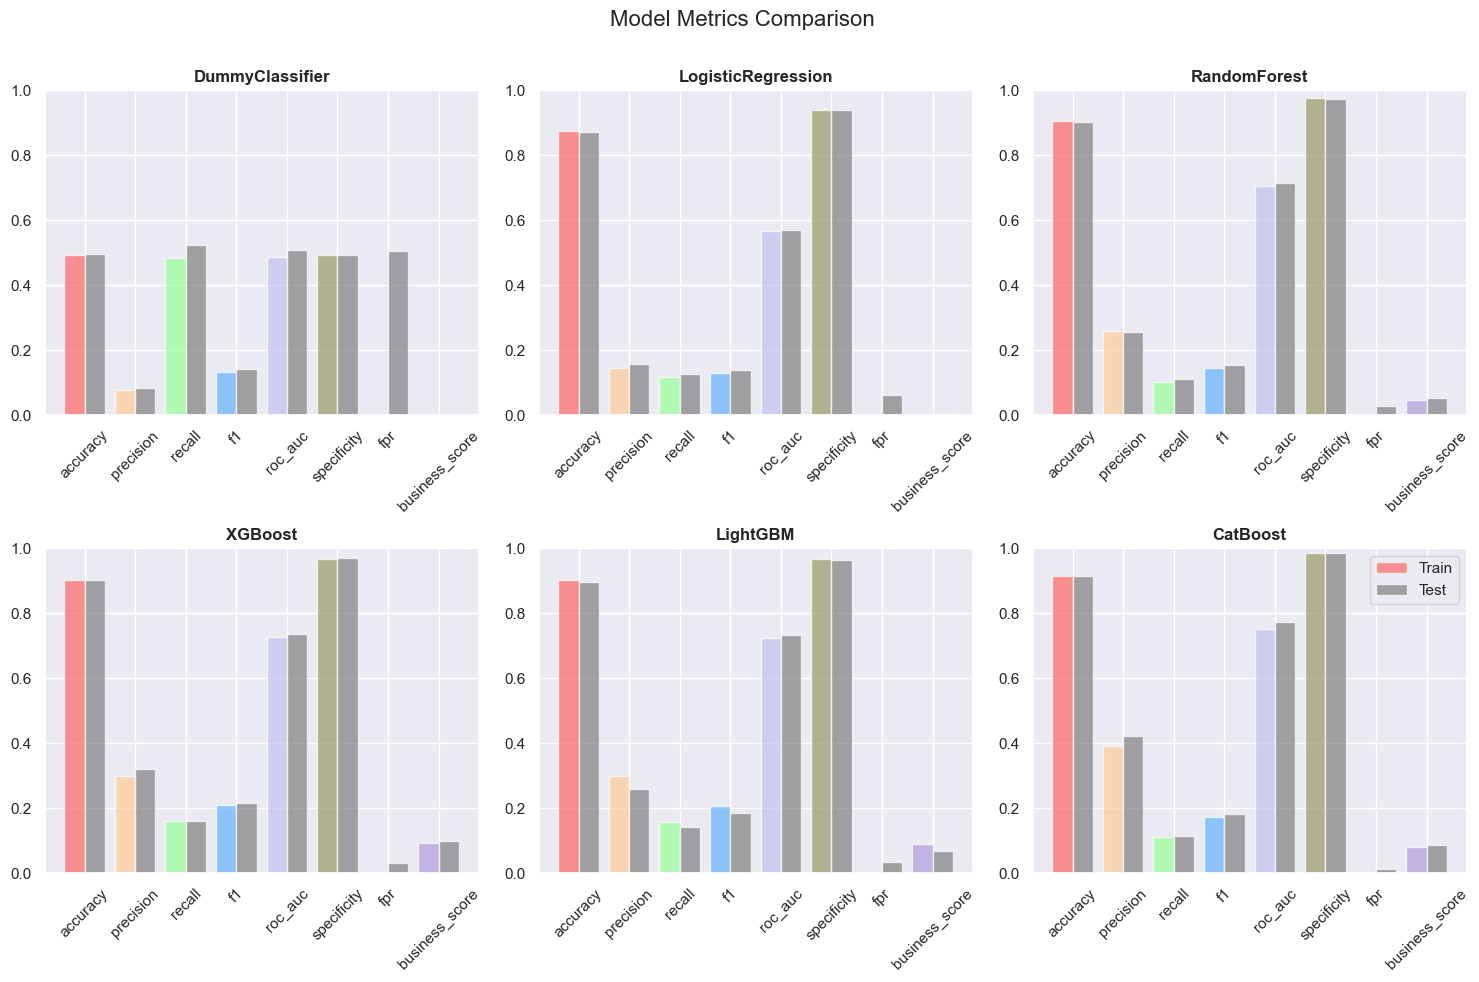

In [45]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv_tuned, results_test_tuned, metrics)

In [46]:
# Comparison between model before and after fine tuning

def plot_metrics_dual_per_model(model_name, train_results, test_results, train_results_ft, test_results_ft):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
    
    # Define colors
    colors = {'Val': 'darkblue', 'Test': 'darkorange', 'Val-FT': 'darkblue', 'Test-FT': 'darkorange'}

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # Add a super title with the model's name
    fig.suptitle(model_name, fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i // 4, i % 4]
        data = [
            train_results.get(metric, 0),
            test_results.get(metric, 0),
            train_results_ft.get(metric, 0),
            test_results_ft.get(metric, 0),
        ]
        x_labels = ['Val', 'Test', 'Val-FT', 'Test-FT']

        ax.bar(x_labels, data, color=[colors[label] for label in x_labels])
        ax.set_ylabel(metric)
        ax.set_title(metric)

        # Rotate x-axis labels
        ax.set_xticklabels(x_labels, rotation=45)

        # Set y-axis limits to vary from 0 to 1
        ax.set_ylim(0, 1)

    plt.tight_layout()  # Set the layout tight
    plt.show()

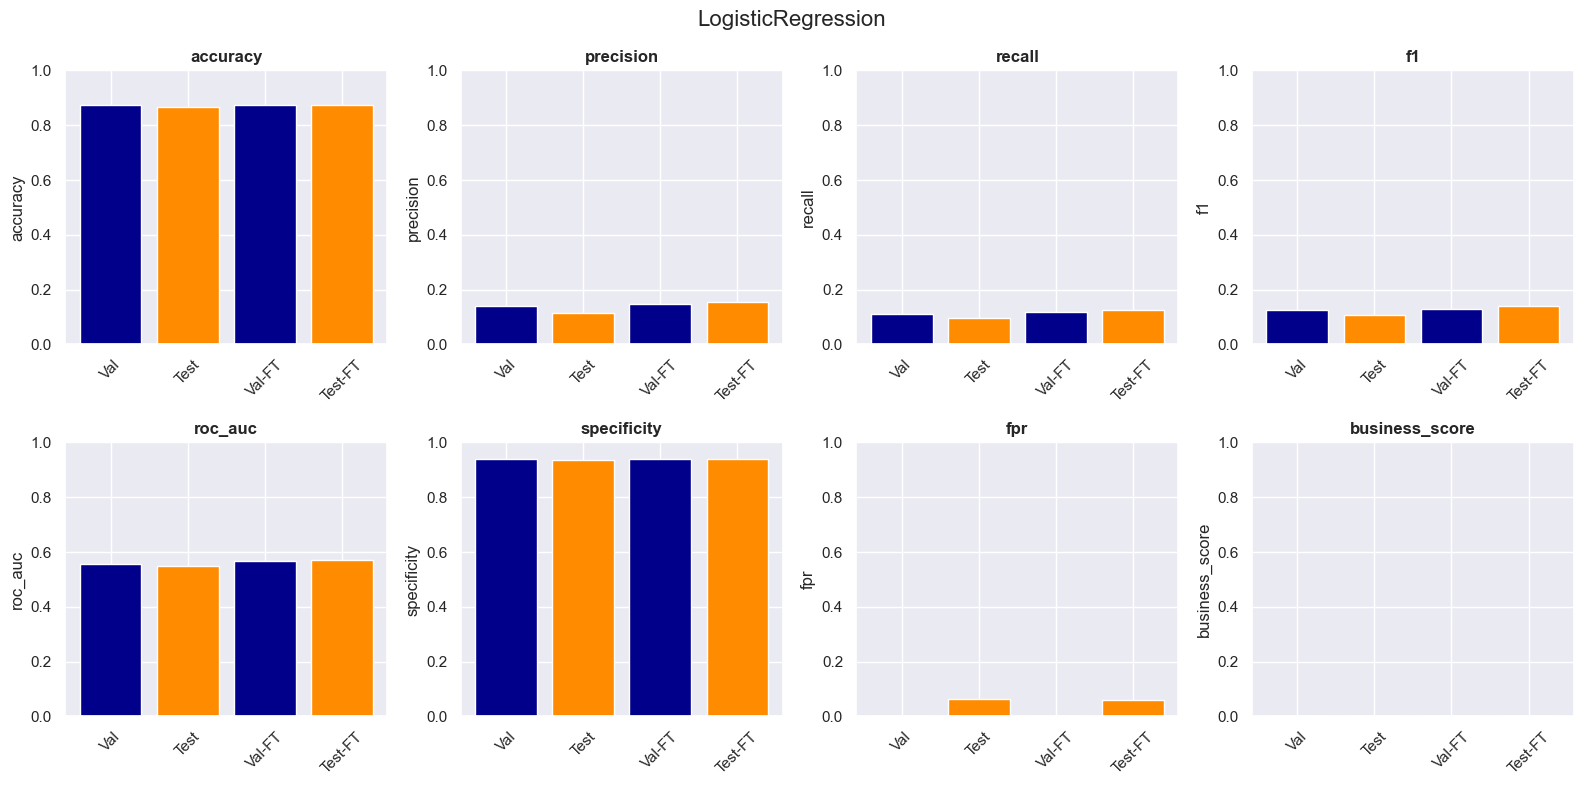

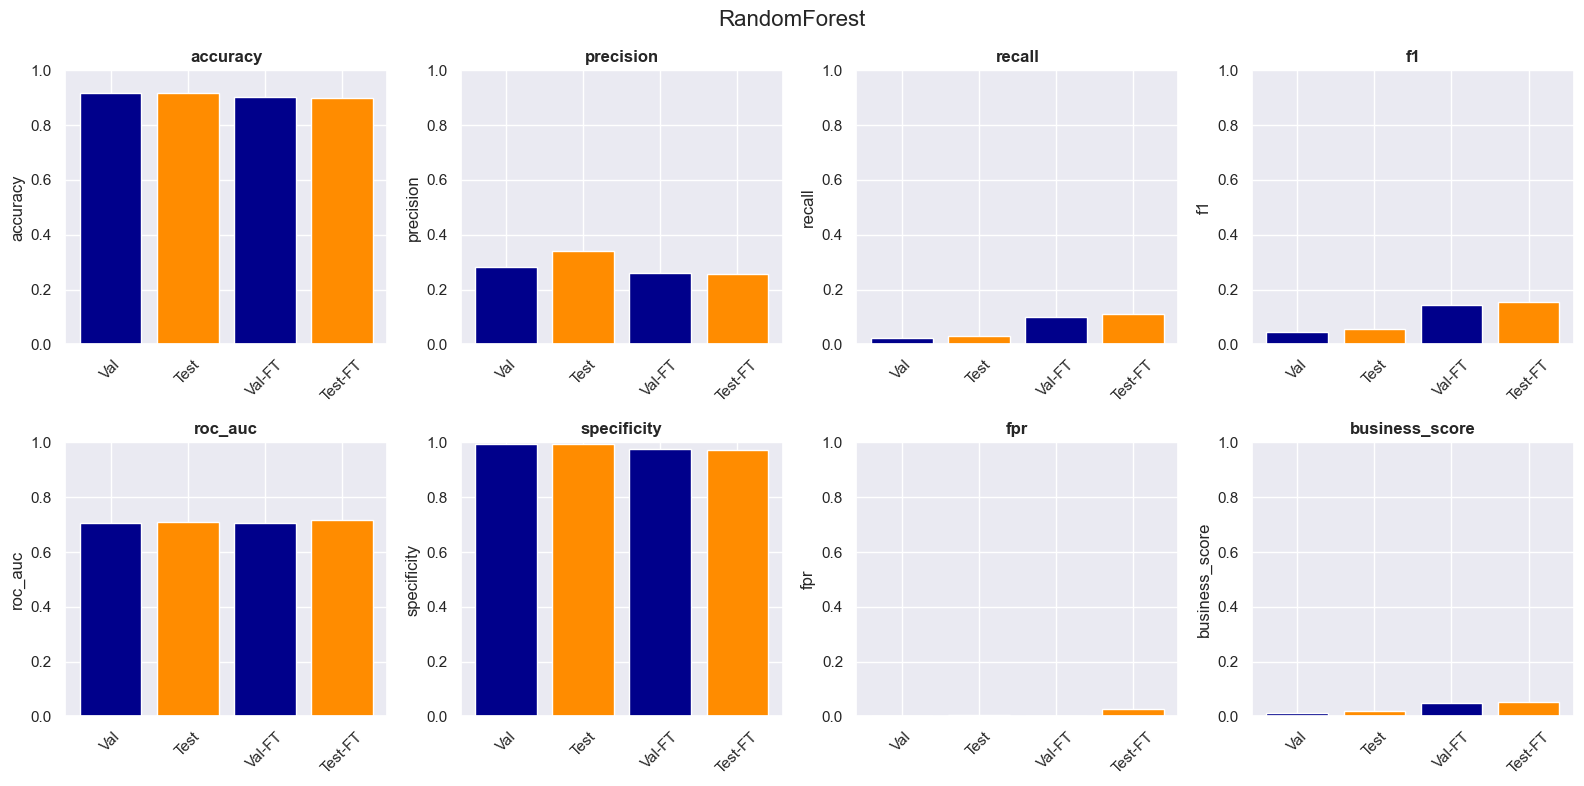

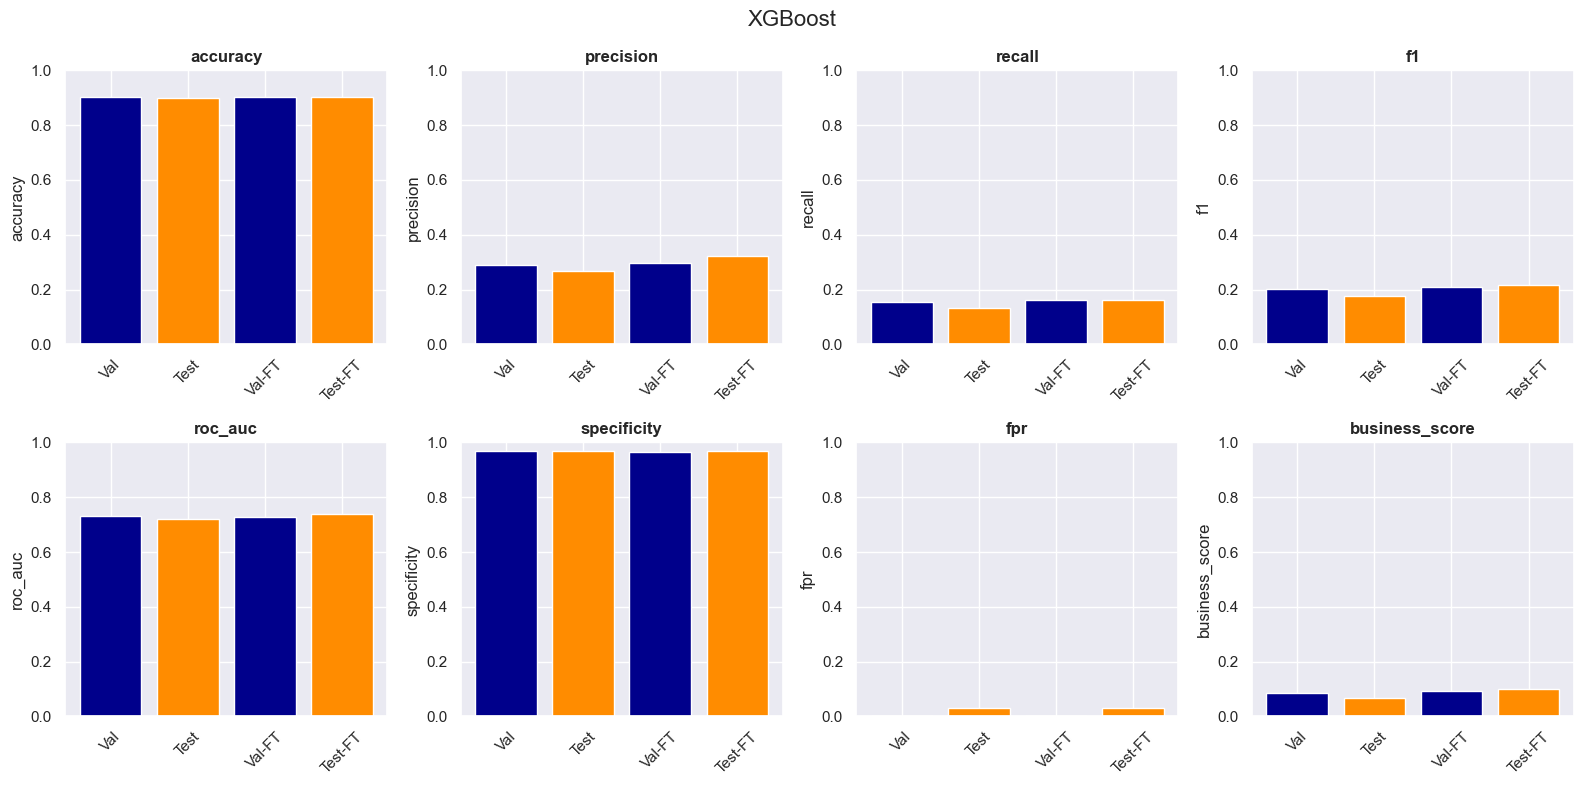

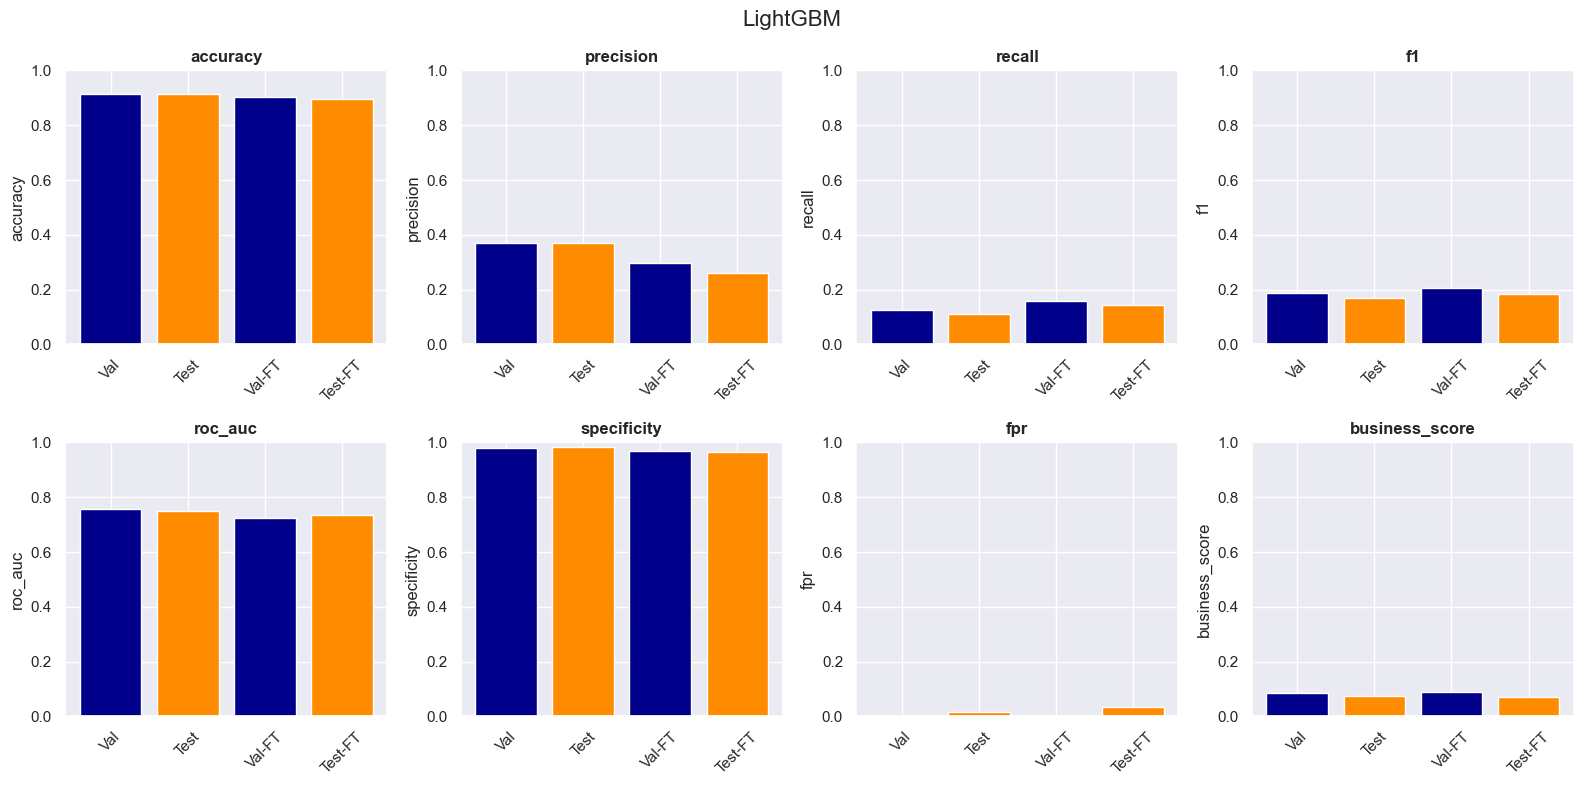

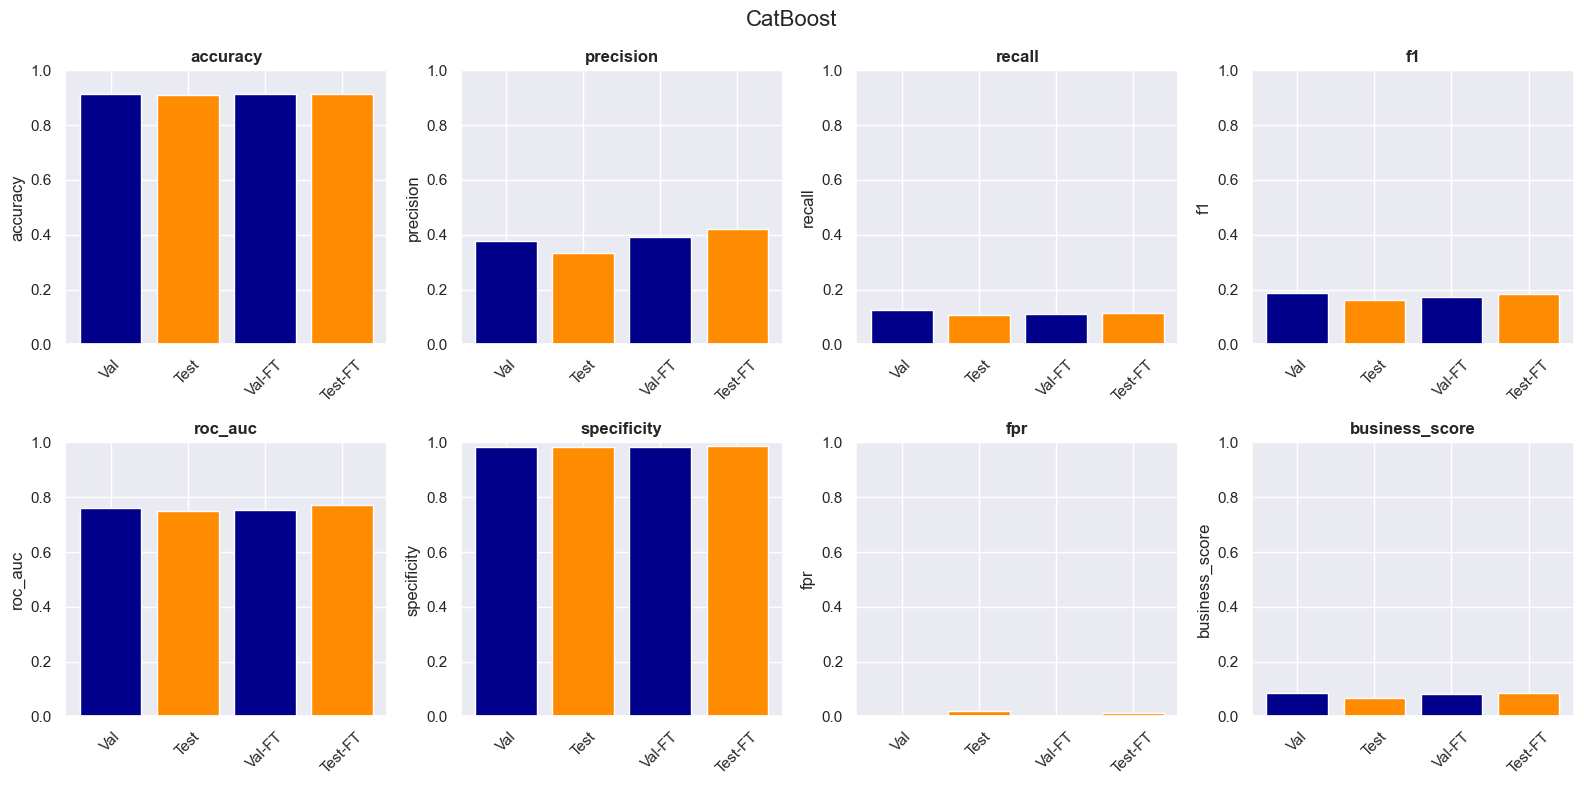

In [47]:
models = {'lr': 'LogisticRegression', 
          'rf': 'RandomForest', 
          'xgbc': 'XGBoost', 
          'lgbmc': 'LightGBM', 
          'cbc': 'CatBoost'}

for model, name in models.items():
    train_results = globals()[model + '_results_cv']
    test_results = globals()[model + '_results_test']
    train_results_ft = globals()[model + 't_results_cv']
    test_results_ft = globals()[model + 't_results_test']
    plot_metrics_dual_per_model(name, train_results, test_results, train_results_ft, test_results_ft)

XGBoost and LightGBM are the best models regarding Business score and Accuracy.
However, **LightGBM** was chosen because it takes a shorter time to train.

In [48]:
# Get best params of LigthGBM and fine tune around them + new hyper parameters

lgbmct_model.named_steps['classifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'cpu'}

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 6.2 µs
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98664
[LightGBM] [Info] Total Bins 98741
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of data 

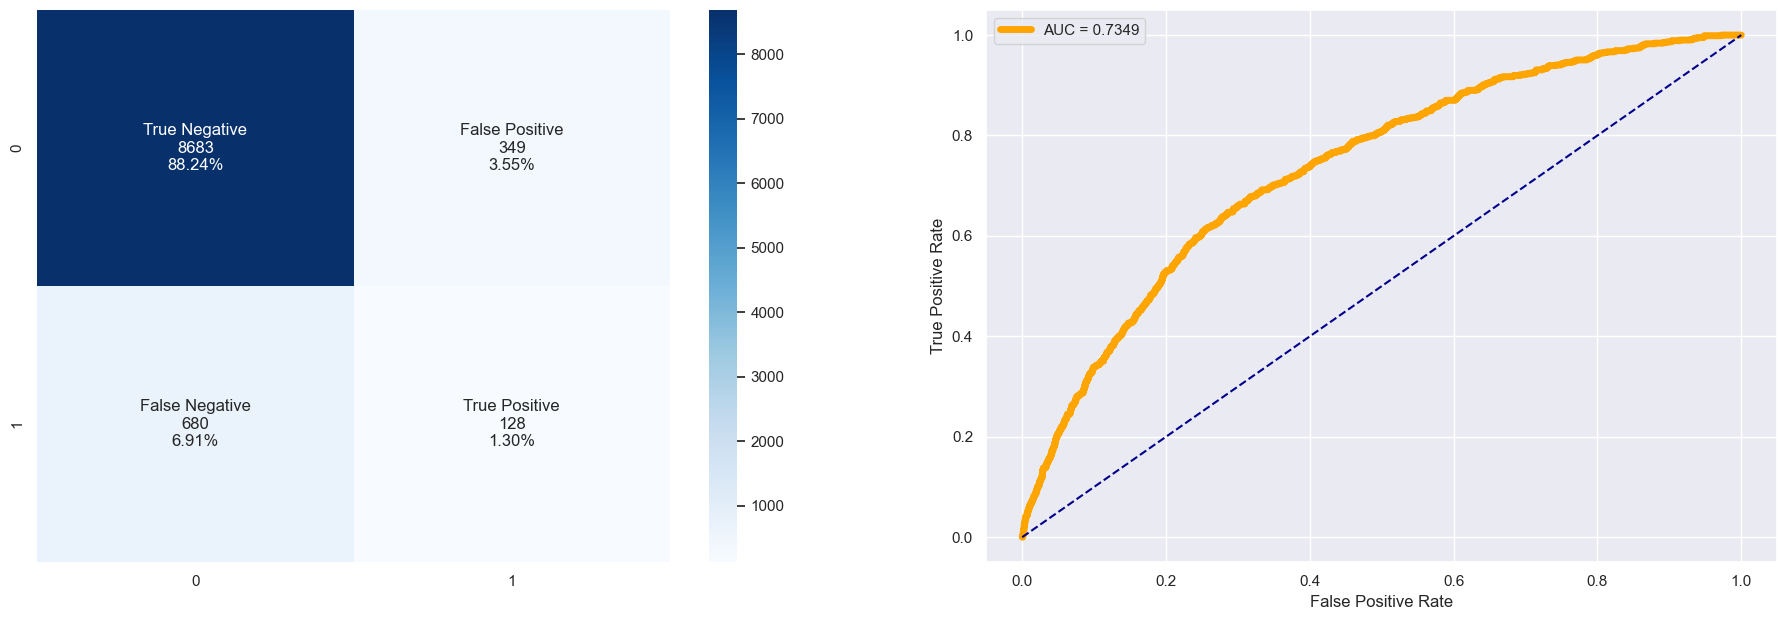

In [49]:
# Fine tune the best model around best params
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned_2'

# Set hyperparameter grid
param_grid = { 
    'classifier__n_estimators': [x for x in range(100, 350, 50)],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
    'classifier__num_leaves': [x for x in range(20, 51, 5)]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2, n_iter=120)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
[LightGBM] [Info] Number of positive: 72369, number of negative: 72369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116736
[LightGBM] [Info] Number of data points in the train set: 144738, number of used features: 513
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

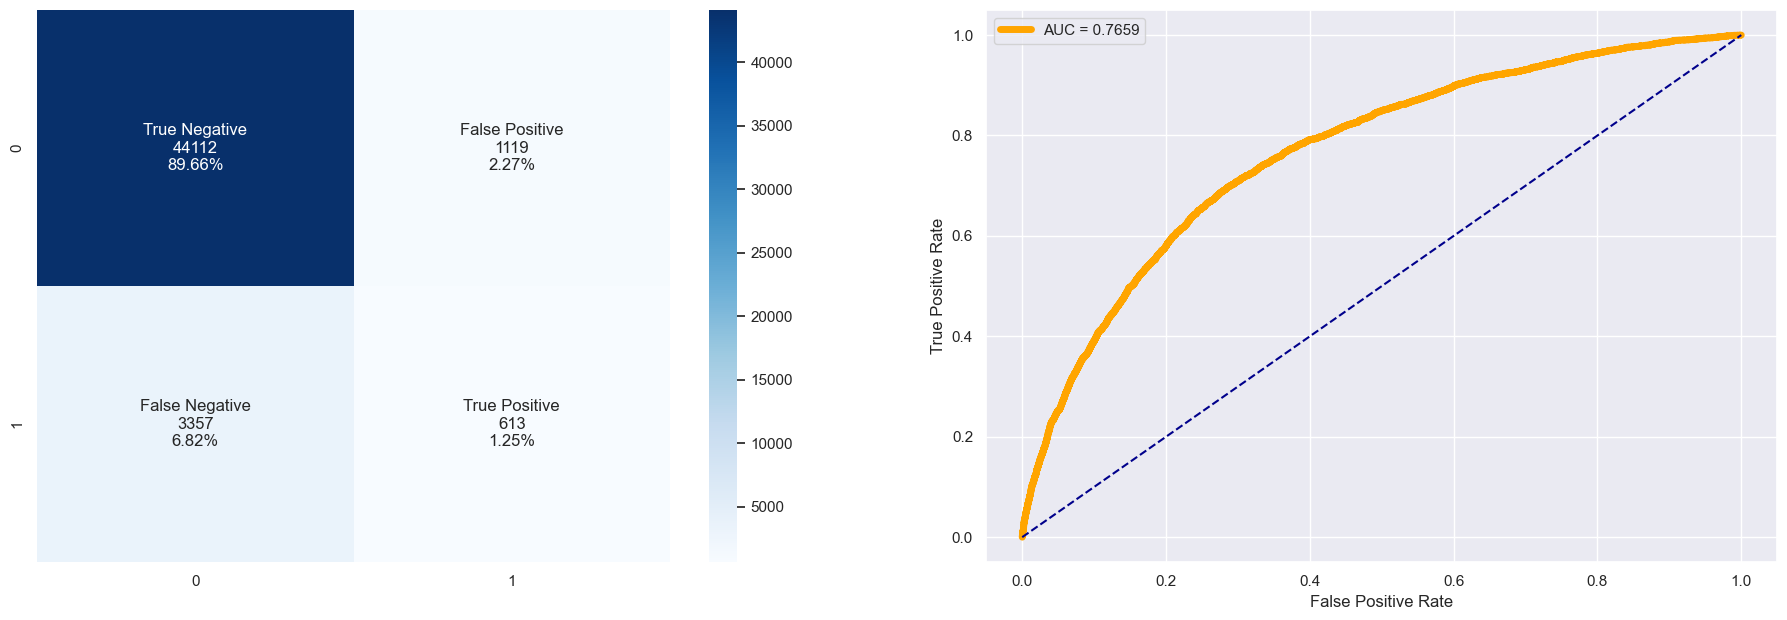

In [50]:
# Train the best model with the whole train dataset
%time
# Get the best params 
best_params = lgbmct_model.named_steps['classifier'].get_params()

# Create LightGBM classifier
lgbmc_final = LGBMClassifier(**best_params)
lgbmc_final_name = 'LightGBM_final'

# Compute results 
lgbmc_final_model, lgbmc_final_results_cv, lgbmc_final_results_test = train_model(lgbmc_final_name, lgbmc_final, cv=5)

In [51]:
lgbmc_final_results_cv

{'accuracy': 0.9078062774365201,
 'precision': 0.3513743319905291,
 'recall': 0.1683249370277078,
 'f1': 0.22758088987313835,
 'roc_auc': 0.7662275304369272,
 'specificity': 0.9727121393668418,
 'fpr': -0.02728786063315831,
 'business_score': 0.11179871765514082,
 'fit_time': 146.79355778694153,
 'execution_time': 150.94507503509521}

In [52]:
lgbmc_final_results_test

{'fit_time': 8.981983184814453,
 'accuracy': 0.9090262393040792,
 'precision': 0.3539260969976905,
 'recall': 0.1544080604534005,
 'f1': 0.21501227639424764,
 'roc_auc': 0.7658640696203374,
 'specificity': 0.9752603303044373,
 'fpr': 0.024739669695562776,
 'business_score': 0.10316006411724296}

#### Threshold selection

In [53]:
def threshold_selection(y_test, y_prob):
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype("int")
        score = business_loss_func(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

In [54]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:

        # Compute best threshold
        o_tpr = tpr[np.argmax(tpr - fpr)]
        o_fpr = fpr[np.argmax(tpr - fpr)]
        o_threshold = thresholds[np.argmax(tpr - fpr)]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [55]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [56]:
# Get proba predictions from xgbc model to be class 1 : repay failure
lgbmc_proba = lgbmc_final_model.predict_proba(x_test)[:,1]

Best results
- Best Threshold:	 0.291
- Best Score:		 0.205




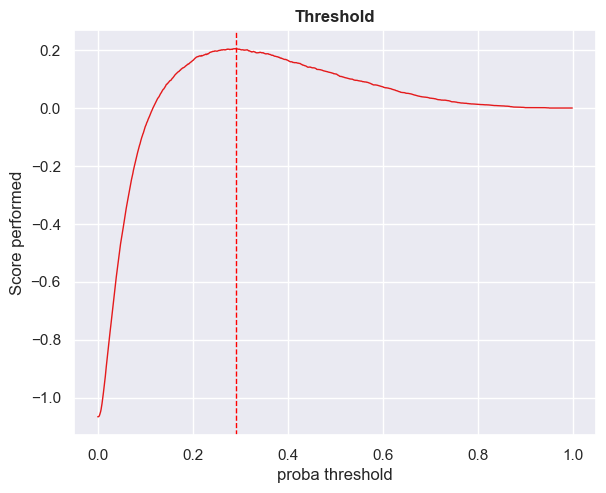

In [57]:
threshold = threshold_selection(y_test, lgbmc_proba)

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower. 
Here it gives us 0.291

Let's try different value of the prediction threshold : [0.5, 0.4, 0.3, 0.2, 0.1]

Printing results for threshold = 0.5
Business score = 0.11762448606669712


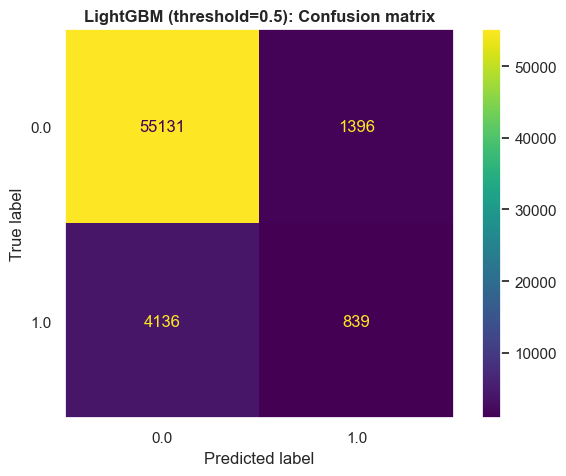

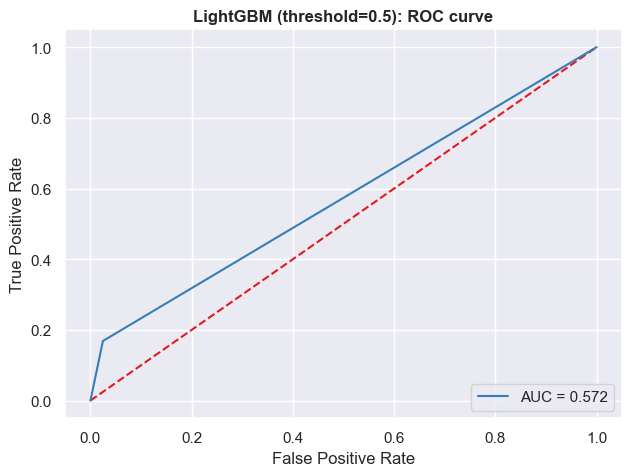

precision    recall  f1-score       support
0.0            0.930214  0.975304  0.952226  56527.000000
1.0            0.375391  0.168643  0.232732   4975.000000
accuracy       0.910052  0.910052  0.910052      0.910052
macro avg      0.652803  0.571974  0.592479  61502.000000
weighted avg   0.885334  0.910052  0.894024  61502.000000

Printing results for threshold = 0.3
Business score = 0.20202832343535862


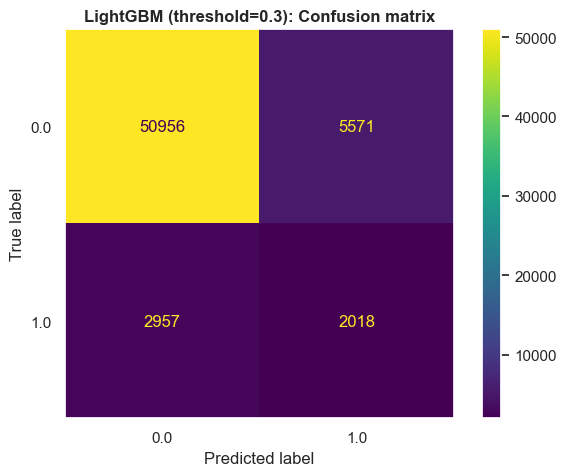

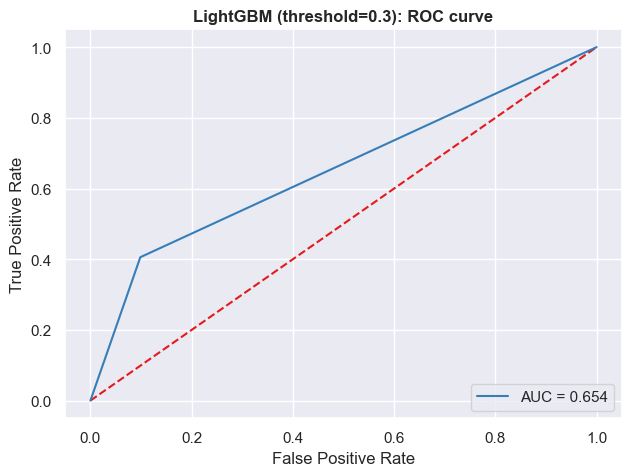

precision    recall  f1-score       support
0.0            0.945152  0.901445  0.922782  56527.000000
1.0            0.265911  0.405628  0.321235   4975.000000
accuracy       0.861338  0.861338  0.861338      0.861338
macro avg      0.605532  0.653537  0.622008  61502.000000
weighted avg   0.890207  0.861338  0.874122  61502.000000

Printing results for threshold = 0.291
Business score = 0.205207857469164


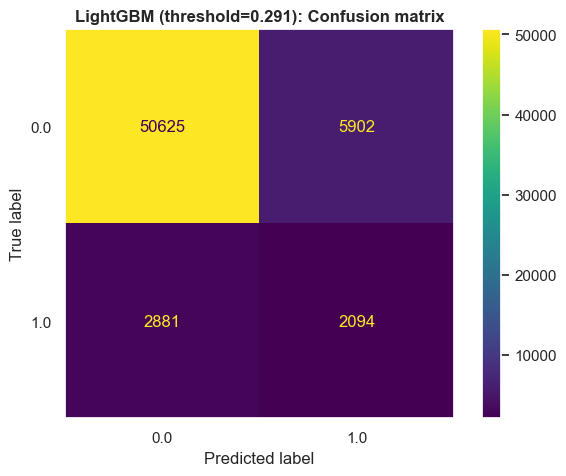

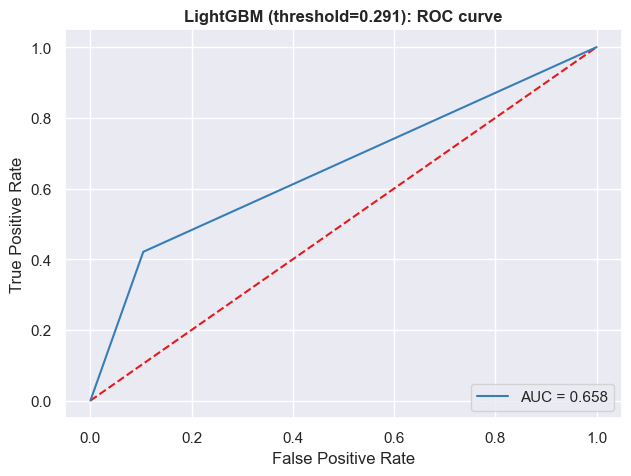

precision    recall  f1-score       support
0.0            0.946156  0.895590  0.920178  56527.000000
1.0            0.261881  0.420905  0.322874   4975.000000
accuracy       0.857192  0.857192  0.857192      0.857192
macro avg      0.604018  0.658247  0.621526  61502.000000
weighted avg   0.890803  0.857192  0.871862  61502.000000

Printing results for threshold = 0.2
Business score = 0.1640383736866149


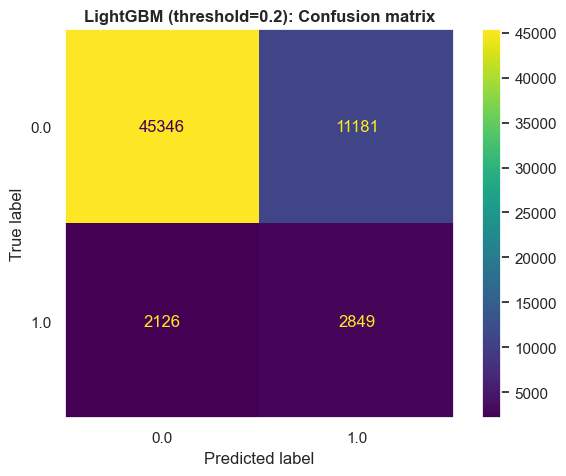

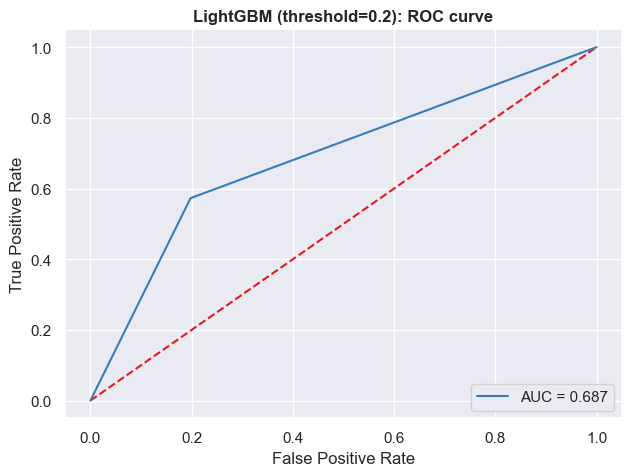

precision    recall  f1-score       support
0.0            0.955216  0.802201  0.872047  56527.000000
1.0            0.203065  0.572663  0.299816   4975.000000
accuracy       0.783633  0.783633  0.783633      0.783633
macro avg      0.579140  0.687432  0.585931  61502.000000
weighted avg   0.894373  0.783633  0.825758  61502.000000

In [58]:
for threshold in [0.5, 0.3, 0.291, 0.2]: 
    print(f'Printing results for threshold = {threshold}')
    lgbm_pred_std = lgbmc_proba >= threshold
    business_score = business_loss_func(y_test, lgbm_pred_std)
    print('Business score =', business_score)
    display_confusion_matrix(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    auc_score = compute_roc_curve(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    clf_report = pd.DataFrame(classification_report(y_test, lgbm_pred_std, output_dict=True)).transpose()
    display(clf_report)


#### Explainer / Feature importance

##### Global feature importance

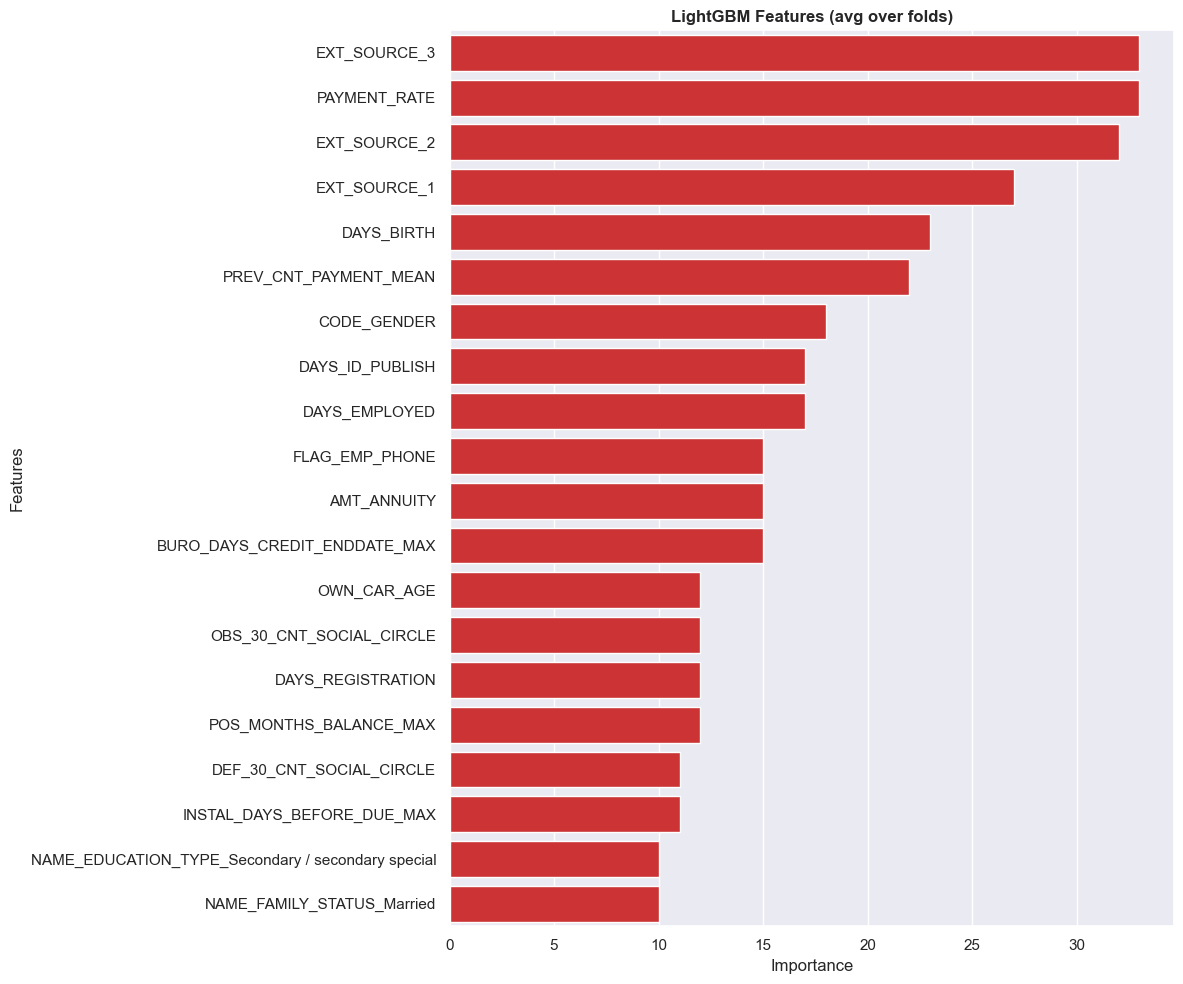

In [59]:
feature_importance_df_ = pd.DataFrame({'importance': lgbmc_final_model.steps[2][1].feature_importances_, 
                                       'feature': x_train.columns})

cols = feature_importance_df_[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:20].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()
plt.show()

##### Local feature importance (SHAP)

In [60]:
shap_explainer = shap.TreeExplainer(lgbmc_final_model.steps[2][1])
shap_values = shap_explainer.shap_values(x_test)

In [62]:
idx = 1000

shap.initjs()
shap.force_plot(shap_explainer.expected_value[0], 
                shap_values[0][idx, :], 
                x_train.iloc[idx, :])

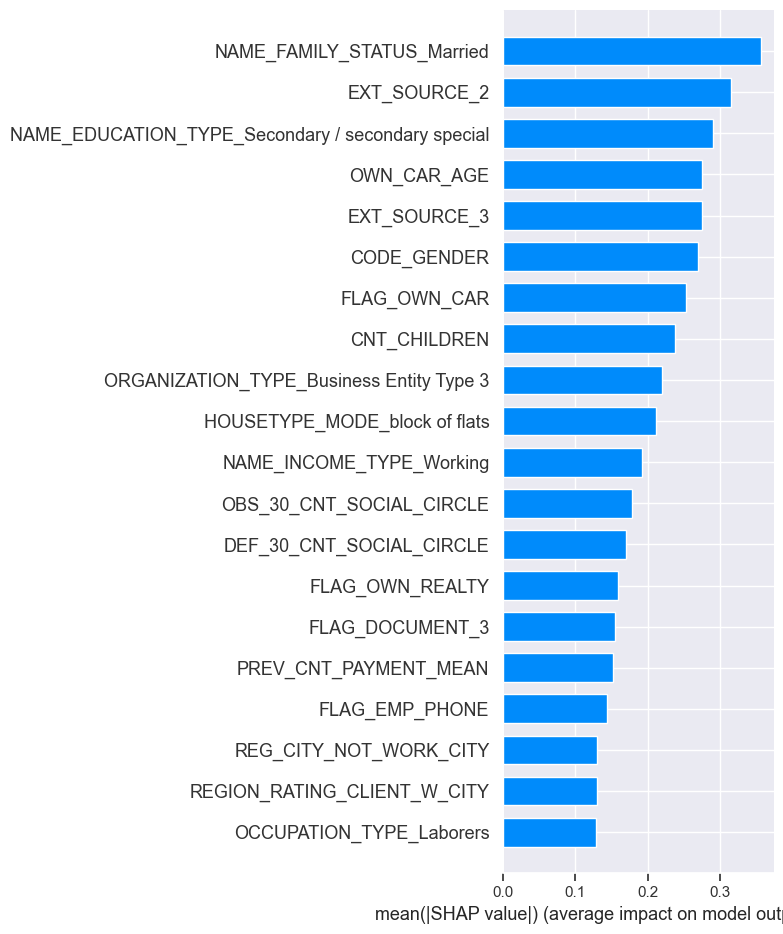

In [63]:
shap.summary_plot(shap_values[0], x_test, plot_type='bar')

#### Export

In [64]:
# Final model

filename = 'models/lightgbm_classifier.pkl'
pickle.dump(lgbmc_final_model.steps[2][1], open(filename, 'wb'))

In [65]:
# SHAP explainer

filename = 'models/lightgbm_shap_explainer.pkl'
pickle.dump(shap_explainer, open(filename, 'wb'))